### Importing required libraries

In [1]:
import os
import glob
import pandas as pd
import numpy as np
import pickle
import json

from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

#import lazypredict
import lightgbm as lgb
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import NearMiss
#from lazypredict.Supervised import LazyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.metrics import confusion_matrix, fbeta_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

# Utility functions

In [3]:
def generate_auc_roc_curve(clf, X_test):
    y_pred_proba = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test,  y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr,tpr,label="AUC ROC Curve with Area Under the curve ="+str(auc))
    plt.legend(loc=4) # Needs to make change legend outside
    plt.show()
    pass

In [4]:
def apply_threshold_filter(perc, data):
    min_count =  int(((100-perc)/100)*data.shape[0] + 1)
    return data.dropna( axis=1, thresh=min_count)

In [5]:
def encoder(data):
    le=LabelEncoder()
    for col in data.columns:
        if data[col].dtype == 'object':
            data[col]=le.fit_transform(data[col].astype(str))
    return data

In [6]:
def filter_high_corr(data, corr):
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))
    to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
    data.drop(to_drop, axis=1, inplace=True)
    return data

In [7]:
def find_corelation(data):
    plt.figure(figsize=(40,40))
    data_corr=data.corr().abs()
    sns.heatmap(data_corr, cmap=plt.cm.RdYlBu_r, vmin=-0.25, annot=True, vmax=0.6)
    plt.title('Correlation Heatmap')
    return data_corr

In [8]:
def train_test_pipeline(data):
    data = apply_threshold_filter(25, data)
    data =  encoder(data)
    corr = find_corelation(data)
    data = filter_high_corr(data, corr)
    return data

In [9]:
def calculate_mean(data):
    cols=data.groupby('SK_ID_CURR').count().columns
    func={i:'mean' for i in cols }
    return func

In [48]:
def extra_data_pipeline(data):
    data.drop([], axis=1, inplace=True)
    data = apply_threshold_filter(25, data)
    func = calculate_mean(data)
    data = encoder(data)
    data_grouped=data.groupby('SK_ID_CURR').agg(func).transform(lambda x: x.fillna(x.mean()))
    corr = find_corelation(data_grouped)
    data_grouped = filter_high_corr(data_grouped, corr)
    return data_grouped
    

# Data

In [11]:
path = os.path.join('../input/openclassroomproject7-data', 'home-credit-default-risk','*.csv')

In [12]:
files = glob.glob(path)
files

[]

In [16]:
description_df = pd.read_csv("../input/openclassroomproject7-data/HomeCredit_columns_description.csv", encoding= 'unicode_escape')
ccb_df = pd.read_csv("../input/openclassroomproject7-data/Credit_Card_Balance.csv")
bb_df = pd.read_csv("../input/openclassroomproject7-data/bureau_balance.csv")
# pos_cash_df = pd.read_csv('../input/openclassroomproject7-data/POS_CASH_balance.csv')
test_df = pd.read_csv("../input/openclassroomproject7-data/application_test.csv")
bureau_df = pd.read_csv("../input/openclassroomproject7-data/bureau_balance.csv")
sample_df = pd.read_csv("../input/openclassroomproject7-data/sample_submission.csv")
ip_df = pd.read_csv("../input/openclassroomproject7-data/Installments_Payments.csv")
pa_df = pd.read_csv("../input/openclassroomproject7-data/Previous_Application.csv")
train_df = pd.read_csv("../input/openclassroomproject7-data/application_train.csv")

In [17]:
#extra ( ot used to find minignfull data there:sample_submission,HomeCredit_columns_description)

# bureau balance . bureau ===== not find anything 

# Understanding data

### Data description

In [18]:
description_df.head()

Unnamed: 0                         Table                 Row  \
0           1  application_{train|test}.csv          SK_ID_CURR   
1           2  application_{train|test}.csv              TARGET   
2           5  application_{train|test}.csv  NAME_CONTRACT_TYPE   
3           6  application_{train|test}.csv         CODE_GENDER   
4           7  application_{train|test}.csv        FLAG_OWN_CAR   

                                         Description Special  
0                           ID of loan in our sample     NaN  
1  Target variable (1 - client with payment diffi...     NaN  
2        Identification if loan is cash or revolving     NaN  
3                               Gender of the client     NaN  
4                      Flag if the client owns a car     NaN

### Training Data

In [19]:
print('Training data shape: ', train_df.shape)
train_df.head()

Training data shape:  (307511, 122)


SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE  \
0         351000.0   Unaccompanied          Working   
1        1129500.0          Family    State servant   
2         135000.0   Unaccompanied          Working   
3         297000.0   Unaccompanied          Working   
4         513000.0   Unaccompanied          Working   

             NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
0  Secondary / secondary special  Single / not married  House / apartment   
1               Higher education               Married  House / apartment   
2  Secondary / secondary special  Single / not married  House / apartment   
3  Secondary / secondary special        Civil marriage  House / apartment   
4  Secondary / secondary special  Single / not married  House / apartment   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.018801       -9461           -637            -3648.0   
1                    0.003541      -16765          -1188            -1186.0   
2                    0.010032      -19046           -225            -4260.0   
3                    0.008019      -19005          -3039            -9833.0   
4                    0.028663      -19932          -3038            -4311.0   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0            -2120          NaN           1               1                0   
1             -291          NaN           1               1                0   
2            -2531         26.0           1               1                1   
3            -2437          NaN           1               1                0   
4            -3458          NaN           1               1                0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  \
0                 1           1           0        Laborers              1.0   
1                 1           1           0      Core staff              2.0   
2                 1           1           0        Laborers              1.0   
3                 1           0           0        Laborers              2.0   
4                 1           0           0      Core staff              1.0   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0                     2                            2   
1                     1                            1   
2                     2                            2   
3                     2                            2   
4                     2                            2   

  WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
0                  WEDNESDAY                       10   
1                     MONDAY                       11   
2                     MONDAY                        9   
3                  WEDNESDAY                       17   
4                   THURSDAY                       11   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   
2                        

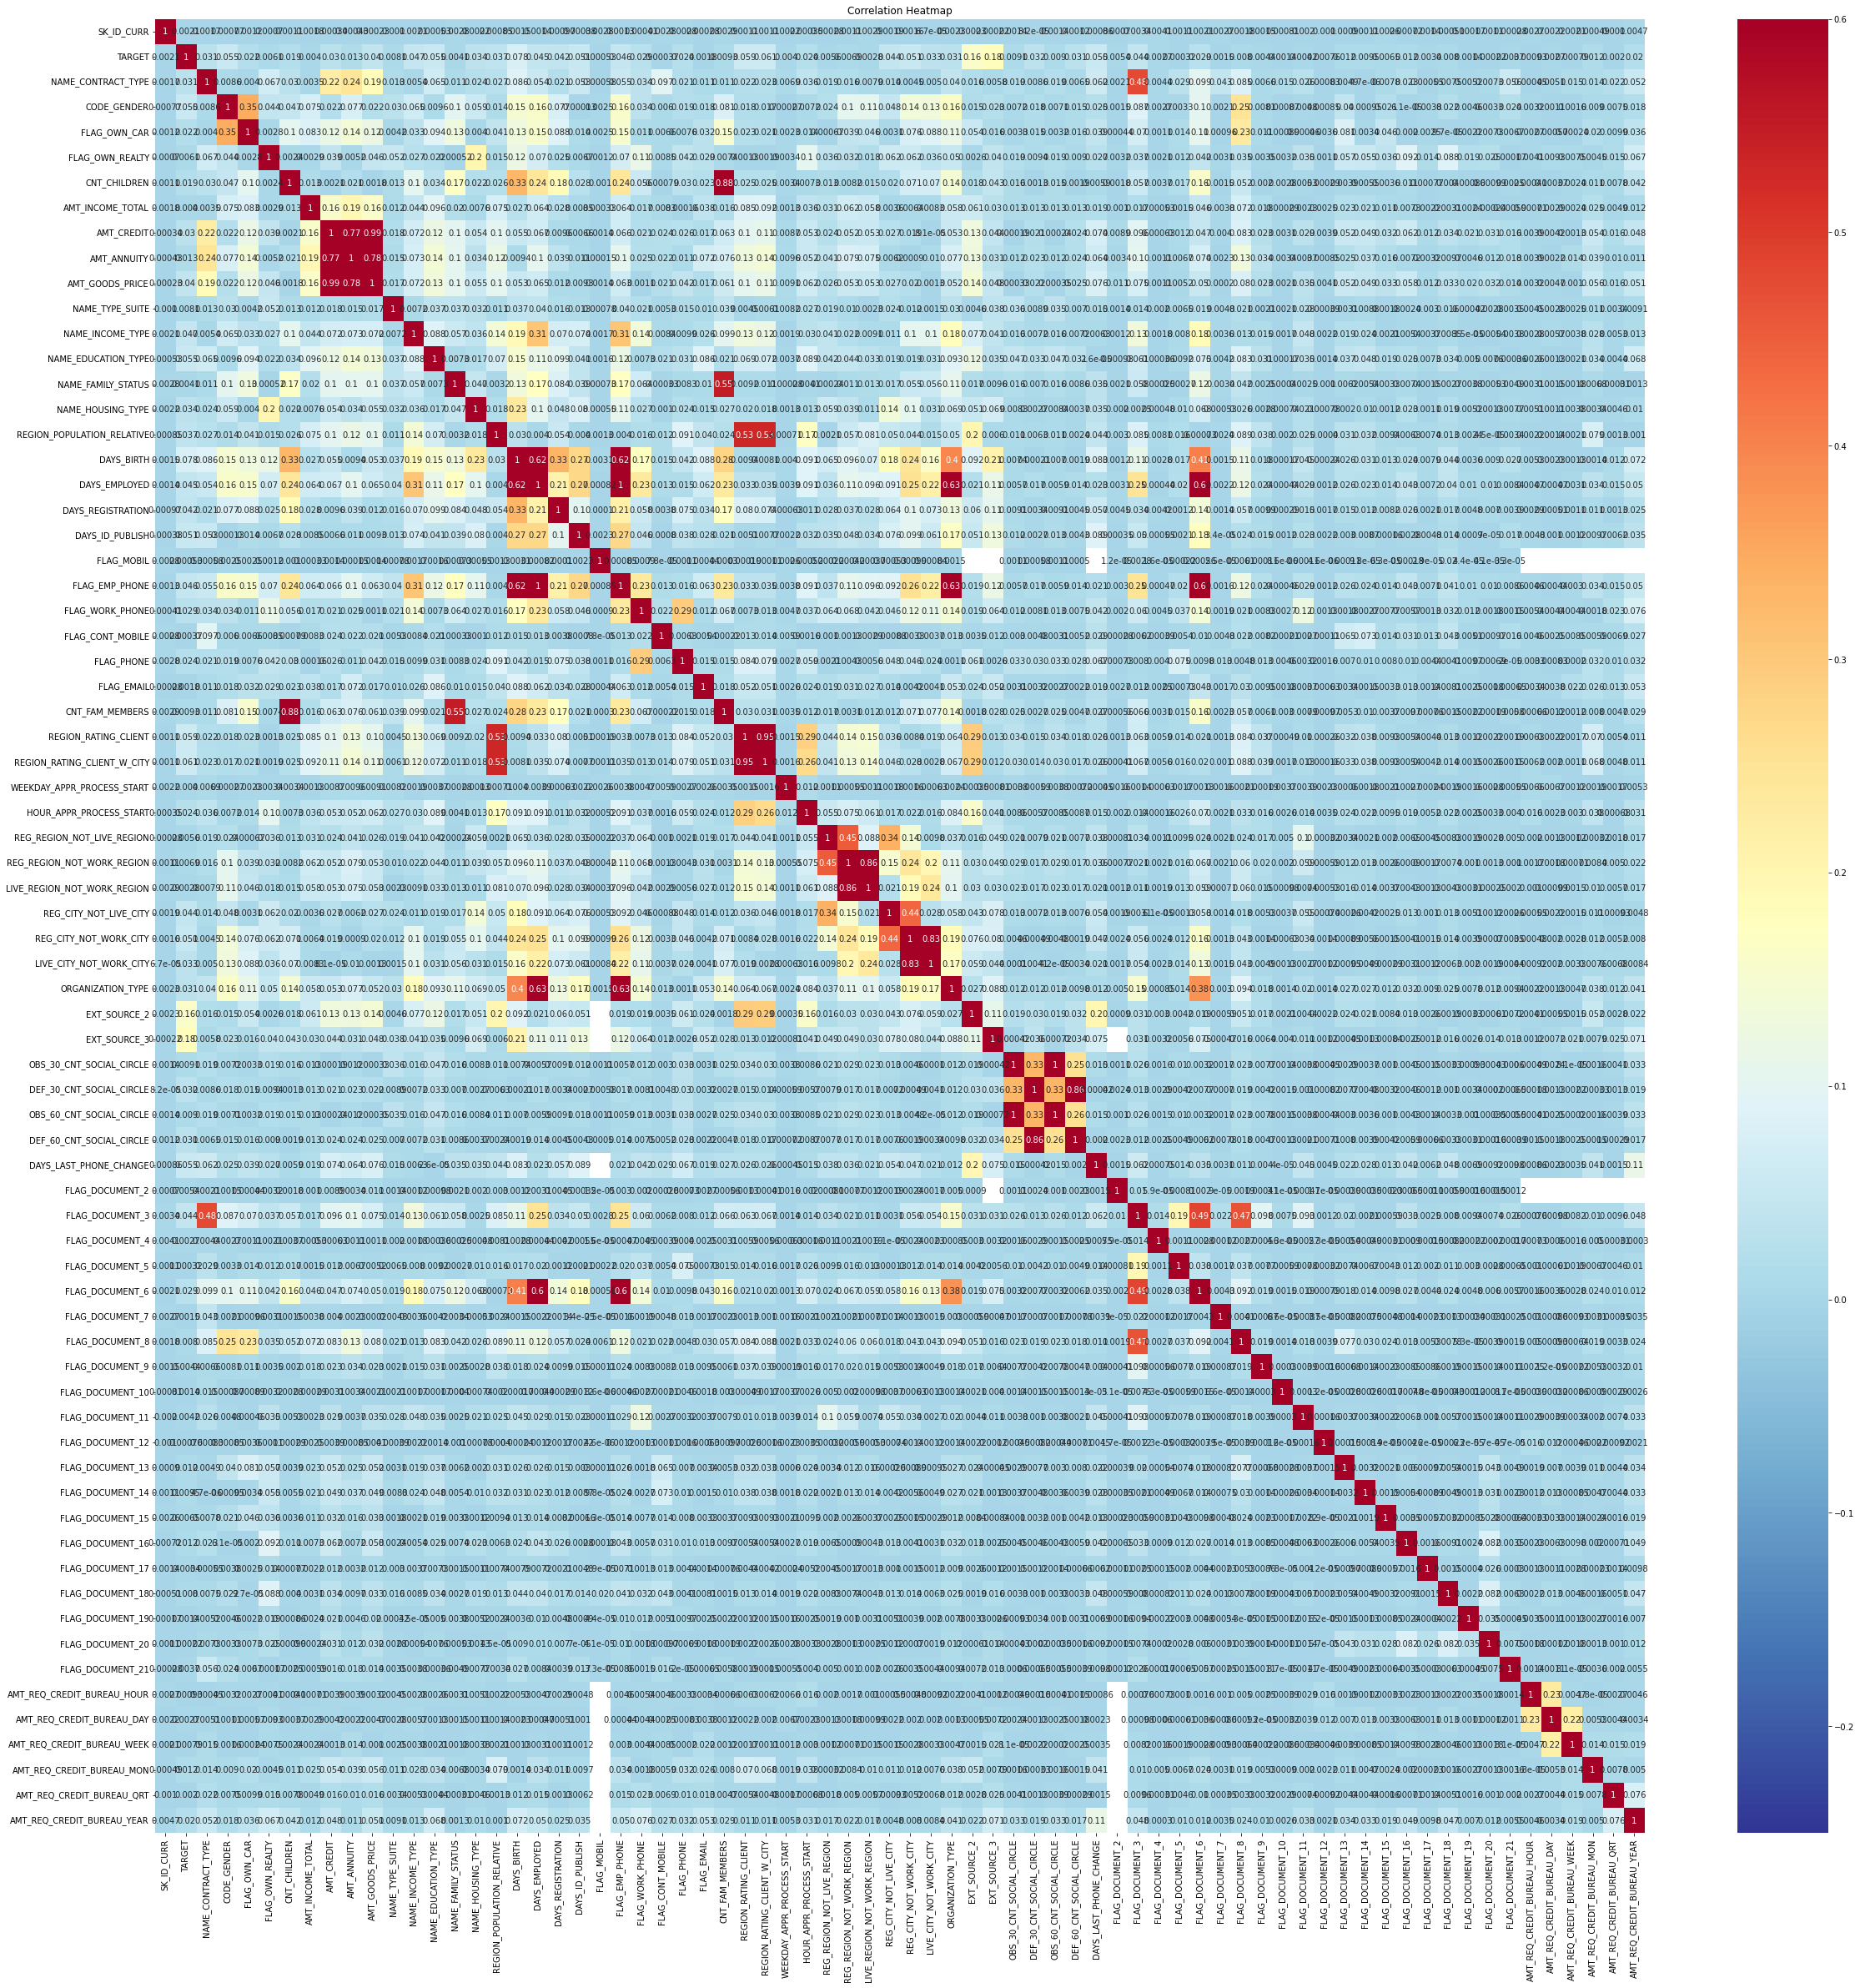

In [20]:
train_data = train_test_pipeline(train_df)

In [21]:
train_data.head()

SK_ID_CURR  TARGET  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  \
0      100002       1                   0            1             0   
1      100003       0                   0            0             0   
2      100004       0                   1            1             1   
3      100006       0                   0            0             0   
4      100007       0                   0            1             0   

   FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0                1             0          202500.0    406597.5      24700.5   
1                0             0          270000.0   1293502.5      35698.5   
2                1             0           67500.0    135000.0       6750.0   
3                1             0          135000.0    312682.5      29686.5   
4                1             0          121500.0    513000.0      21865.5   

   NAME_TYPE_SUITE  NAME_INCOME_TYPE  NAME_EDUCATION_TYPE  NAME_FAMILY_STATUS  \
0                6                 7                    4                   3   
1                1                 4                    1                   1   
2                6                 7                    4                   3   
3                6                 7                    4                   0   
4                6                 7                    4                   3   

   NAME_HOUSING_TYPE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
0                  1                    0.018801       -9461           -637   
1                  1                    0.003541      -16765          -1188   
2                  1                    0.010032      -19046           -225   
3                  1                    0.008019      -19005          -3039   
4                  1                    0.028663      -19932          -3038   

   DAYS_REGISTRATION  DAYS_ID_PUBLISH  FLAG_MOBIL  FLAG_WORK_PHONE  \
0            -3648.0            -2120           1                0   
1            -1186.0             -291           1                0   
2            -4260.0            -2531           1                1   
3            -9833.0            -2437           1                0   
4            -4311.0            -3458           1                0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  CNT_FAM_MEMBERS  \
0                 1           1           0              1.0   
1                 1           1           0              2.0   
2                 1           1           0              1.0   
3                 1           0           0              2.0   
4                 1           0           0              1.0   

   REGION_RATING_CLIENT  WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
0                     2                           6                       10   
1                     1                           1                       11   
2                     2                           1                        9   
3                     2                           6                       17   
4                     2                           4                       11   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   
2                           0                           0   
3                           0                           0   
4                           0                           0   

   LIVE_REGION_NOT_WORK_REGION  REG_CITY_NOT_LIVE_CITY  \
0                            0                       0   
1                            0                       0   
2                            0                       0   
3                            0                       0   
4                            0                       0   

   REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY  ORGANIZATION_TYPE  \
0                       0                        0       

### Testing Data

In [22]:
print('Testing data shape: ', test_df.shape)
test_df.head()

Testing data shape:  (48744, 121)


SK_ID_CURR NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
0      100001         Cash loans           F            N               Y   
1      100005         Cash loans           M            N               Y   
2      100013         Cash loans           M            Y               Y   
3      100028         Cash loans           F            N               Y   
4      100038         Cash loans           M            Y               N   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          135000.0    568800.0      20560.5         450000.0   
1             0           99000.0    222768.0      17370.0         180000.0   
2             0          202500.0    663264.0      69777.0         630000.0   
3             2          315000.0   1575000.0      49018.5        1575000.0   
4             1          180000.0    625500.0      32067.0         625500.0   

  NAME_TYPE_SUITE NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
0   Unaccompanied          Working               Higher education   
1   Unaccompanied          Working  Secondary / secondary special   
2             NaN          Working               Higher education   
3   Unaccompanied          Working  Secondary / secondary special   
4   Unaccompanied          Working  Secondary / secondary special   

  NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  REGION_POPULATION_RELATIVE  \
0            Married  House / apartment                    0.018850   
1            Married  House / apartment                    0.035792   
2            Married  House / apartment                    0.019101   
3            Married  House / apartment                    0.026392   
4            Married  House / apartment                    0.010032   

   DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  \
0      -19241          -2329            -5170.0             -812          NaN   
1      -18064          -4469            -9118.0            -1623          NaN   
2      -20038          -4458            -2175.0            -3503          5.0   
3      -13976          -1866            -2000.0            -4208          NaN   
4      -13040          -2191            -4000.0            -4262         16.0   

   FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  \
0           1               1                0                 1           0   
1           1               1                0                 1           0   
2           1               1                0                 1           0   
3           1               1                0                 1           1   
4           1               1                1                 1           0   

   FLAG_EMAIL     OCCUPATION_TYPE  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
0           1                 NaN              2.0                     2   
1           0  Low-skill Laborers              2.0                     2   
2           0             Drivers              2.0                     2   
3           0         Sales staff              4.0                     2   
4           0                 NaN              3.0                     2   

   REGION_RATING_CLIENT_W_CITY WEEKDAY_APPR_PROCESS_START  \
0                            2                    TUESDAY   
1                            2                     FRIDAY   
2                            2                     MONDAY   
3                            2                  WEDNESDAY   
4                            2                     FRIDAY   

   HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
0                       18                           0   
1                        9                           0   
2                       14                           0   
3                       11                           0   
4                        5                           0   

   REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  \
0                   

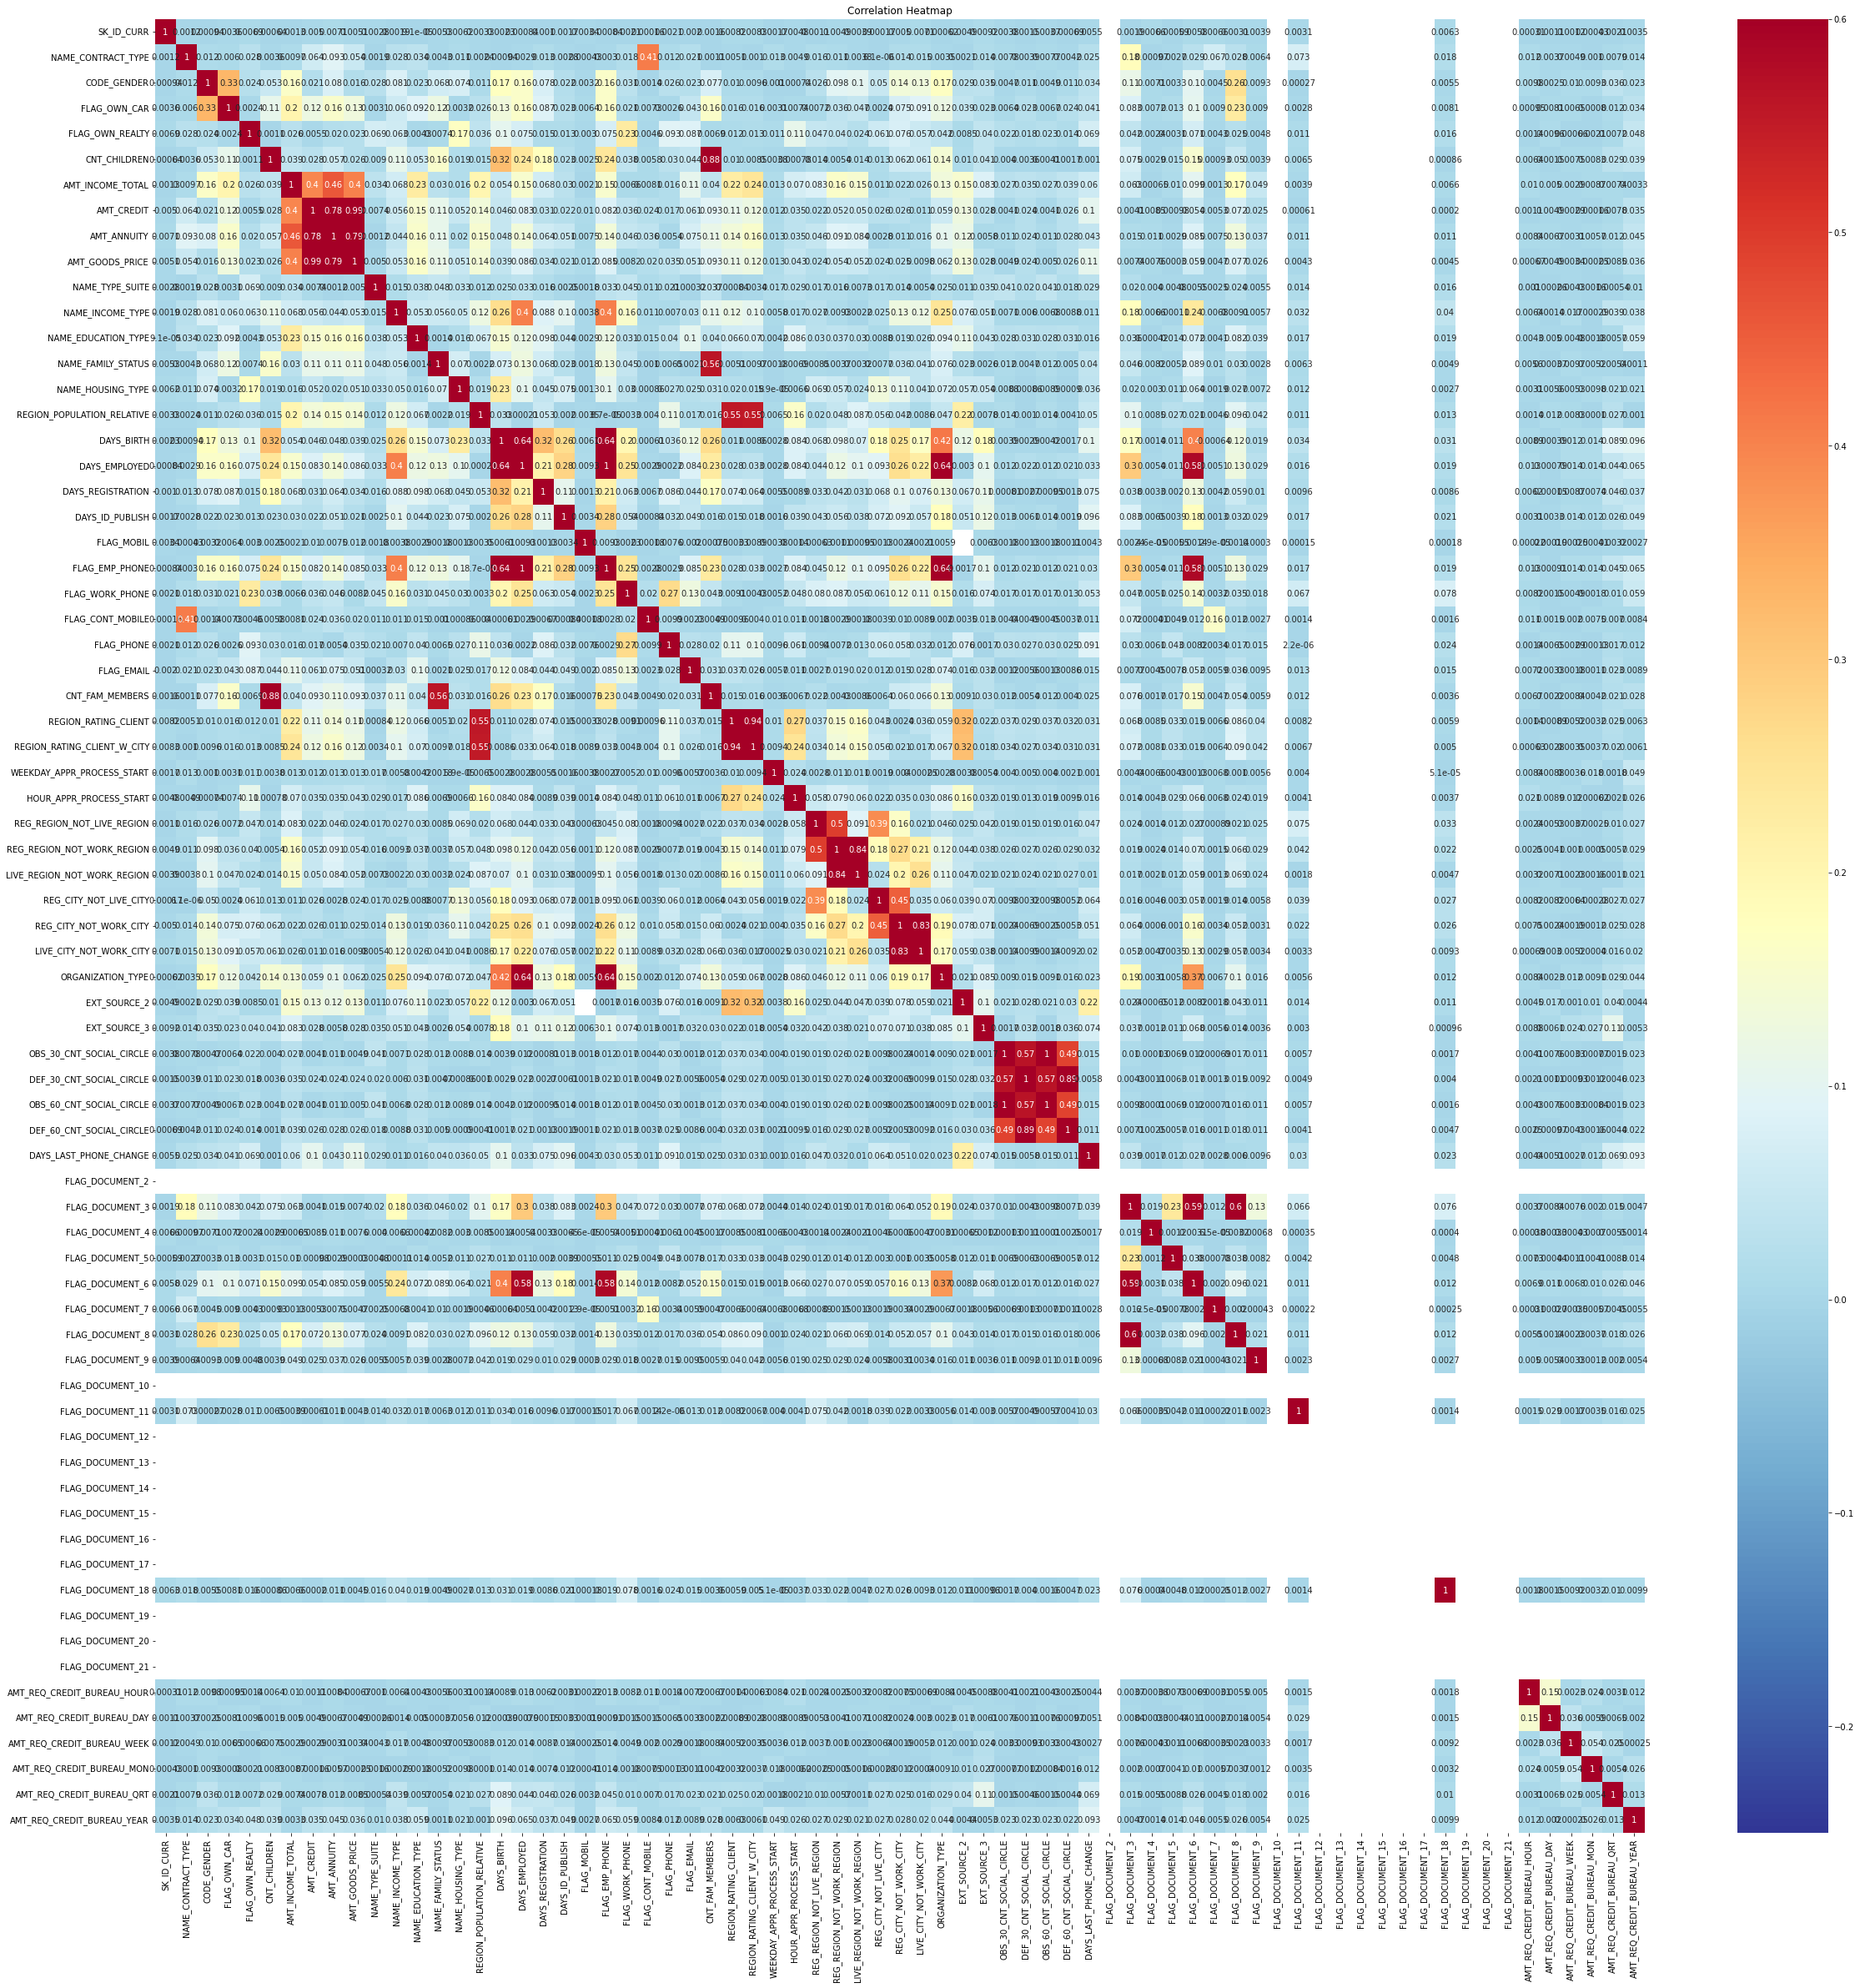

In [23]:
test_data = train_test_pipeline(test_df)

In [24]:
# Saving the train data
train_data.to_csv('train_data.csv')

In [25]:
test_data.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
0      100001                   0            0             0                1   
1      100005                   0            1             0                1   
2      100013                   0            1             1                1   
3      100028                   0            0             0                1   
4      100038                   0            1             1                0   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  NAME_TYPE_SUITE  \
0             0          135000.0    568800.0      20560.5                6   
1             0           99000.0    222768.0      17370.0                6   
2             0          202500.0    663264.0      69777.0                7   
3             2          315000.0   1575000.0      49018.5                6   
4             1          180000.0    625500.0      32067.0                6   

   NAME_INCOME_TYPE  NAME_EDUCATION_TYPE  NAME_FAMILY_STATUS  \
0                 6                    1                   1   
1                 6                    4                   1   
2                 6                    1                   1   
3                 6                    4                   1   
4                 6                    4                   1   

   NAME_HOUSING_TYPE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
0                  1                    0.018850      -19241          -2329   
1                  1                    0.035792      -18064          -4469   
2                  1                    0.019101      -20038          -4458   
3                  1                    0.026392      -13976          -1866   
4                  1                    0.010032      -13040          -2191   

   DAYS_REGISTRATION  DAYS_ID_PUBLISH  FLAG_MOBIL  FLAG_WORK_PHONE  \
0            -5170.0             -812           1                0   
1            -9118.0            -1623           1                0   
2            -2175.0            -3503           1                0   
3            -2000.0            -4208           1                0   
4            -4000.0            -4262           1                1   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  CNT_FAM_MEMBERS  \
0                 1           0           1              2.0   
1                 1           0           0              2.0   
2                 1           0           0              2.0   
3                 1           1           0              4.0   
4                 1           0           0              3.0   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0                     2                            2   
1                     2                            2   
2                     2                            2   
3                     2                            2   
4                     2                            2   

   WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
0                           5                       18   
1                           0                        9   
2                           1                       14   
3                           6                       11   
4                           0                        5   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   
2                           0                           0   
3                           0                           0   
4                           0                           0   

   LIVE_REGION_NOT_WORK_REGION  REG_CITY_NOT_LIVE_CITY  \
0                            0                       0   
1                            0                       0   
2                            0                       0   
3                            0                       0   
4                            0  

In [26]:
# Saving the test data
test_data.to_csv('test_data.csv')

# Train and Test Data Understanding

## Predicting column

In [27]:
train_data['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

<AxesSubplot:ylabel='Frequency'>

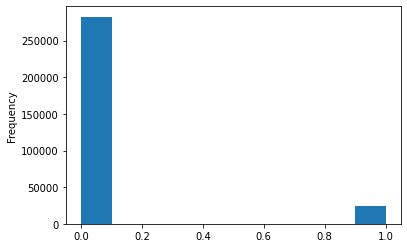

In [28]:
train_data['TARGET'].astype(int).plot.hist()

From above graph, we can observed that data is imbalanced.

## Data Visualization

In [29]:
train_labels = train_data['TARGET']

print('Training Features shape: ', train_data.shape)
print('Testing Features shape: ', test_data.shape)

Training Features shape:  (307511, 68)
Testing Features shape:  (48744, 68)


In [30]:
desc = description_df[description_df['Table']=='application_{train|test}.csv'][['Row', 'Description']]

for i in range(len(desc)):
    print(desc.iloc[i]['Row'] +str(" : ")+ desc.iloc[i]['Description'])
    print()

SK_ID_CURR : ID of loan in our sample

TARGET : Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)

NAME_CONTRACT_TYPE : Identification if loan is cash or revolving

CODE_GENDER : Gender of the client

FLAG_OWN_CAR : Flag if the client owns a car

FLAG_OWN_REALTY : Flag if client owns a house or flat

CNT_CHILDREN : Number of children the client has

AMT_INCOME_TOTAL : Income of the client

AMT_CREDIT : Credit amount of the loan

AMT_ANNUITY : Loan annuity

AMT_GOODS_PRICE : For consumer loans it is the price of the goods for which the loan is given

NAME_TYPE_SUITE : Who was accompanying client when he was applying for the loan

NAME_INCOME_TYPE : Clients income type (businessman, working, maternity leave,)

NAME_EDUCATION_TYPE : Level of highest education the client achieved

NAME_FAMILY_STATUS : Family status of the client

NAME_HOUSING_TYPE : Wha

In [31]:
# finding the number of days from the date of birth

for col in train_data.columns:
    if train_data[col].dtype == 'object':
        print("object column %s have %s unique values"%(str(col),train_data[col].nunique()))
        print(train_data[col].value_counts())
        print('-------------')
        ax = sns.catplot(x=col, kind="count", data=train_data, height=6, aspect=2.2)
        for axes in ax.axes.flat:
            axes.set_xticklabels(axes.get_xticklabels(),rotation = 45,horizontalalignment = 'right')

Text(0.5, 1.0, 'Distribution of Ages')

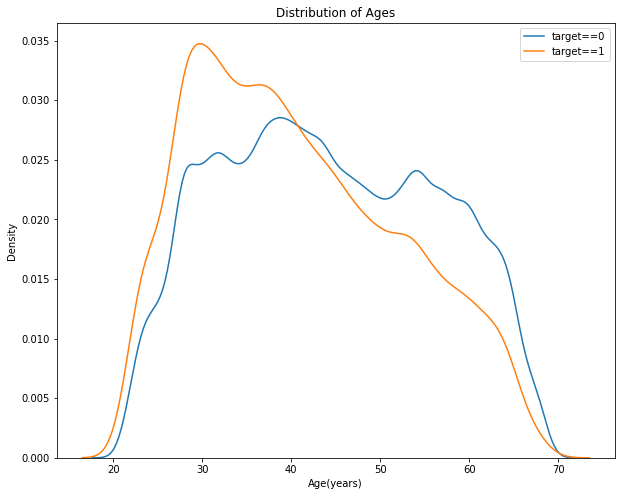

In [32]:
#converting the days into age  then see where the density of people that get accepted and rejected
plt.figure(figsize=(10,8))

train_data['DAYS_BIRTH']=train_data['DAYS_BIRTH'].abs()
sns.kdeplot(train_data.loc[train_data['TARGET']==0,'DAYS_BIRTH']/365,label='target==0')
sns.kdeplot(train_data.loc[train_data['TARGET']==1,'DAYS_BIRTH']/365,label='target==1')
plt.legend()
plt.xlabel('Age(years)')
plt.ylabel('Density')
plt.title('Distribution of Ages')

In [33]:
train_data[['TARGET','DAYS_BIRTH']].head(10)

TARGET  DAYS_BIRTH
0       1        9461
1       0       16765
2       0       19046
3       0       19005
4       0       19932
5       0       16941
6       0       13778
7       0       18850
8       0       20099
9       0       14469

In [34]:
#converting it to years
age_data = train_data[['TARGET','DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH']/365
age_data.head(10)


TARGET  DAYS_BIRTH  YEARS_BIRTH
0       1        9461    25.920548
1       0       16765    45.931507
2       0       19046    52.180822
3       0       19005    52.068493
4       0       19932    54.608219
5       0       16941    46.413699
6       0       13778    37.747945
7       0       18850    51.643836
8       0       20099    55.065753
9       0       14469    39.641096

In [35]:
# Bin the age data ( putting people in age group by using linspace is a grouping of every 5 years)

age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'],bins=np.linspace(20,70,num=11))
age_data.head(10)

TARGET  DAYS_BIRTH  YEARS_BIRTH  YEARS_BINNED
0       1        9461    25.920548  (25.0, 30.0]
1       0       16765    45.931507  (45.0, 50.0]
2       0       19046    52.180822  (50.0, 55.0]
3       0       19005    52.068493  (50.0, 55.0]
4       0       19932    54.608219  (50.0, 55.0]
5       0       16941    46.413699  (45.0, 50.0]
6       0       13778    37.747945  (35.0, 40.0]
7       0       18850    51.643836  (50.0, 55.0]
8       0       20099    55.065753  (55.0, 60.0]
9       0       14469    39.641096  (35.0, 40.0]

In [36]:
# Group by the bin and calculate averages
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

TARGET    DAYS_BIRTH  YEARS_BIRTH
YEARS_BINNED                                     
(20.0, 25.0]  0.123036   8532.795625    23.377522
(25.0, 30.0]  0.111436  10155.219250    27.822518
(30.0, 35.0]  0.102814  11854.848377    32.479037
(35.0, 40.0]  0.089414  13707.908253    37.555913
(40.0, 45.0]  0.078491  15497.661233    42.459346
(45.0, 50.0]  0.074171  17323.900441    47.462741
(50.0, 55.0]  0.066968  19196.494791    52.593136
(55.0, 60.0]  0.055314  20984.262742    57.491131
(60.0, 65.0]  0.052737  22780.547460    62.412459
(65.0, 70.0]  0.037270  24292.614340    66.555108

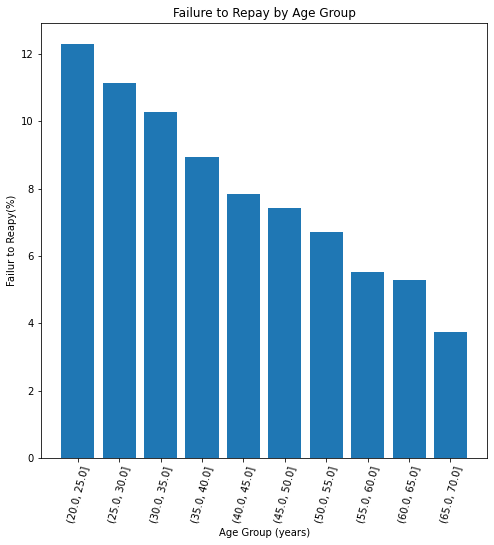

In [37]:
plt.figure(figsize=(8,8))

# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), 100*age_groups['TARGET'])

# Plot labeling
plt.xticks(rotation=75);
plt.xlabel('Age Group (years)');
plt.ylabel('Failur to Reapy(%)')
plt.title('Failure to Repay by Age Group');

In [38]:
ext_data = train_data[['TARGET','EXT_SOURCE_2','EXT_SOURCE_3','DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

TARGET  EXT_SOURCE_2  EXT_SOURCE_3  DAYS_BIRTH
TARGET        1.000000     -0.160472     -0.178919   -0.078239
EXT_SOURCE_2 -0.160472      1.000000      0.109167    0.091996
EXT_SOURCE_3 -0.178919      0.109167      1.000000    0.205478
DAYS_BIRTH   -0.078239      0.091996      0.205478    1.000000

Text(0.5, 1.0, 'Correlation Heatmap')

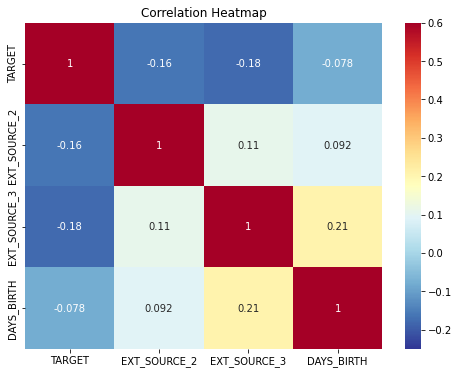

In [39]:
# find relation with target value to see if some columns has relatioons
plt.figure(figsize=(8,6))

sns.heatmap(ext_data_corrs, cmap=plt.cm.RdYlBu_r, vmin=-0.25, annot=True, vmax=0.6)
plt.title('Correlation Heatmap')

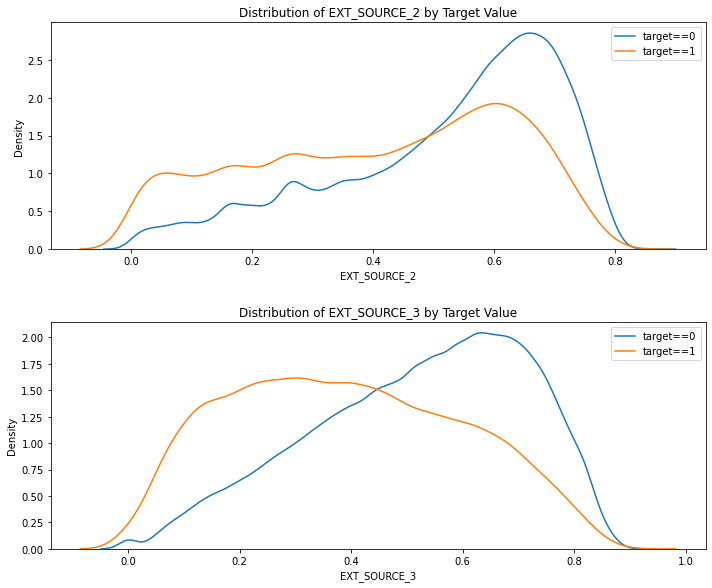

In [40]:
#this is to see if EXT sources does provide a reason to make the decision of begging accepted or denied
plt.figure(figsize=(10,12))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_2','EXT_SOURCE_3']):
    plt.subplot(3,1,i+1)
    
    sns.kdeplot(train_data.loc[train_data['TARGET']==0,source],label='target==0')
    sns.kdeplot(train_data.loc[train_data['TARGET']==1,source],label='target==1')
    
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' %source)
    plt.ylabel('Density')
    plt.legend()
    
plt.tight_layout(h_pad=2.5)

In [41]:
train_data.head()

SK_ID_CURR  TARGET  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  \
0      100002       1                   0            1             0   
1      100003       0                   0            0             0   
2      100004       0                   1            1             1   
3      100006       0                   0            0             0   
4      100007       0                   0            1             0   

   FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0                1             0          202500.0    406597.5      24700.5   
1                0             0          270000.0   1293502.5      35698.5   
2                1             0           67500.0    135000.0       6750.0   
3                1             0          135000.0    312682.5      29686.5   
4                1             0          121500.0    513000.0      21865.5   

   NAME_TYPE_SUITE  NAME_INCOME_TYPE  NAME_EDUCATION_TYPE  NAME_FAMILY_STATUS  \
0                6                 7                    4                   3   
1                1                 4                    1                   1   
2                6                 7                    4                   3   
3                6                 7                    4                   0   
4                6                 7                    4                   3   

   NAME_HOUSING_TYPE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
0                  1                    0.018801        9461           -637   
1                  1                    0.003541       16765          -1188   
2                  1                    0.010032       19046           -225   
3                  1                    0.008019       19005          -3039   
4                  1                    0.028663       19932          -3038   

   DAYS_REGISTRATION  DAYS_ID_PUBLISH  FLAG_MOBIL  FLAG_WORK_PHONE  \
0            -3648.0            -2120           1                0   
1            -1186.0             -291           1                0   
2            -4260.0            -2531           1                1   
3            -9833.0            -2437           1                0   
4            -4311.0            -3458           1                0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  CNT_FAM_MEMBERS  \
0                 1           1           0              1.0   
1                 1           1           0              2.0   
2                 1           1           0              1.0   
3                 1           0           0              2.0   
4                 1           0           0              1.0   

   REGION_RATING_CLIENT  WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
0                     2                           6                       10   
1                     1                           1                       11   
2                     2                           1                        9   
3                     2                           6                       17   
4                     2                           4                       11   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   
2                           0                           0   
3                           0                           0   
4                           0                           0   

   LIVE_REGION_NOT_WORK_REGION  REG_CITY_NOT_LIVE_CITY  \
0                            0                       0   
1                            0                       0   
2                            0                       0   
3                            0                       0   
4                            0                       0   

   REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY  ORGANIZATION_TYPE  \
0                       0                        0       

In [42]:
# converting the funds to % and see if the percentage of there funds would give them a chance to get accepted
train_data_domain = train_data.copy()

train_data_domain['CREDIT_INCOME_PERCENT'] = train_data_domain['AMT_CREDIT'] / train_data_domain['AMT_INCOME_TOTAL']
train_data_domain['ANNUITY_INCOME_PERCENT'] = train_data_domain['AMT_ANNUITY'] / train_data_domain['AMT_INCOME_TOTAL']
train_data_domain['CREDIT_TERM'] = train_data_domain['AMT_ANNUITY'] / train_data_domain['AMT_CREDIT']
train_data_domain['DAYS_EMPLOYED_PERCENT'] = train_data_domain['DAYS_EMPLOYED'] / train_data_domain['DAYS_BIRTH']

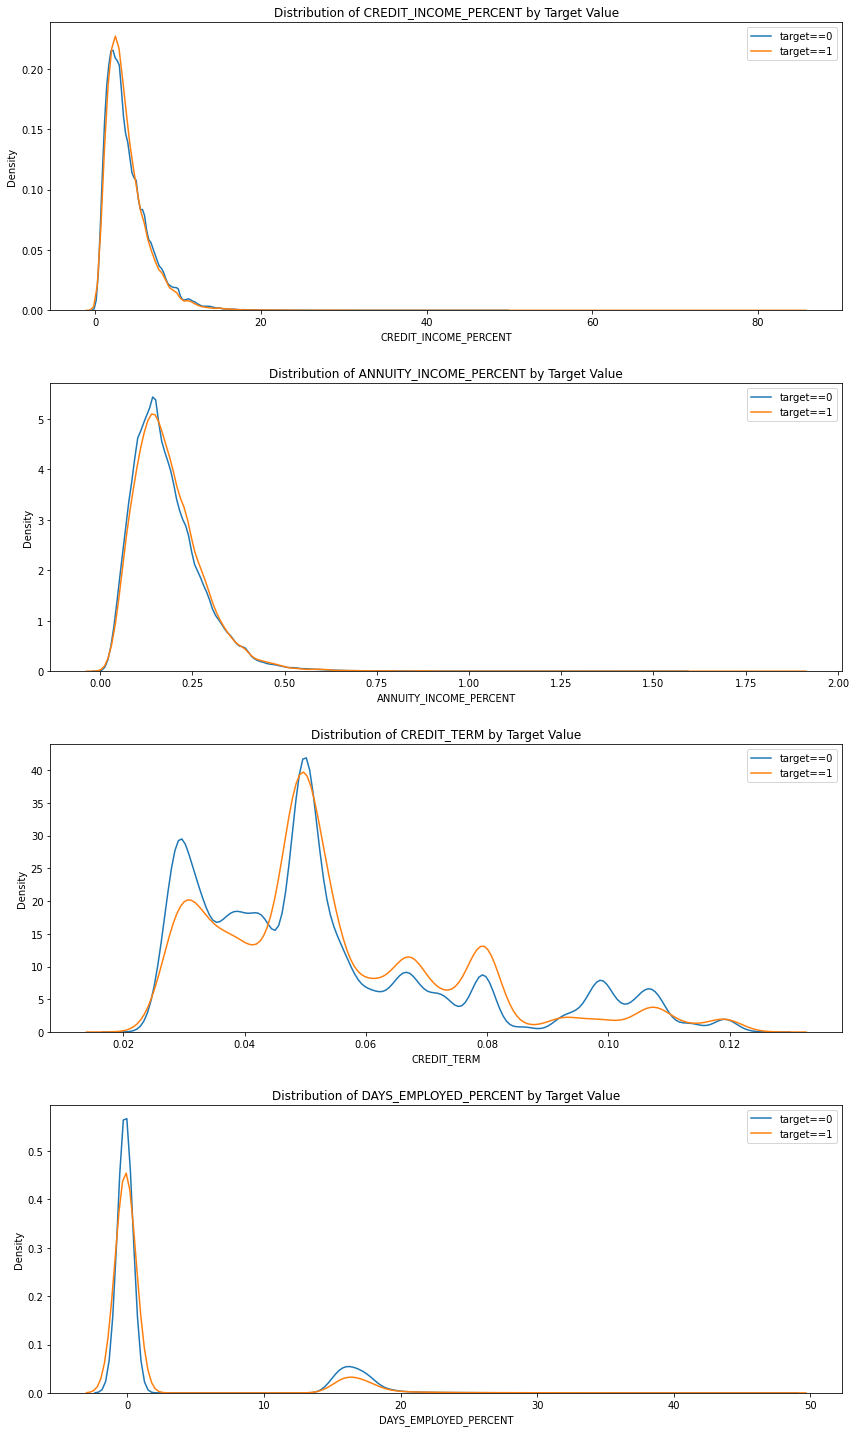

In [43]:
plt.figure(figsize=(12,20))
for i, feature in enumerate(['CREDIT_INCOME_PERCENT','ANNUITY_INCOME_PERCENT','CREDIT_TERM','DAYS_EMPLOYED_PERCENT']):
    plt.subplot(4,1,i+1)
    sns.kdeplot(train_data_domain.loc[train_data_domain['TARGET']==0,feature],label='target==0')
    sns.kdeplot(train_data_domain.loc[train_data_domain['TARGET']==1,feature],label='target==1')
    
    plt.title('Distribution of %s by Target Value' % feature)
    plt.xlabel('%s' % feature)# Saving the train domain data
# train_data_domain.to_csv('/content/drive/MyDrive/Ali/API_Dashboard/train_data_domain.csv')
    plt.ylabel('Density')
    plt.legend()
    
plt.tight_layout(h_pad=2.5)

It shows there's no relevance between the all charts based on the his income and years of works

In [44]:
# # Saving the train domain data
train_data_domain.to_csv('train_data_domain.csv')

# Cleaning/Visualization - Credit Card Balance & Installments Payments

## Credit Card Balance

In [45]:
desc = description_df[description_df['Table']=='credit_card_balance.csv'][['Row', 'Description']]
for i in range(len(desc)):
    print(desc.iloc[i]['Row'] +str(" : ")+ desc.iloc[i]['Description'])
    print()

SK_ID_PREV  : ID of previous credit in Home credit related to loan in our sample. (One loan in our sample can have 0,1,2 or more previous loans in Home Credit)

SK_ID_CURR : ID of loan in our sample

MONTHS_BALANCE : Month of balance relative to application date (-1 means the freshest balance date)

AMT_BALANCE : Balance during the month of previous credit

AMT_CREDIT_LIMIT_ACTUAL : Credit card limit during the month of the previous credit

AMT_DRAWINGS_ATM_CURRENT : Amount drawing at ATM during the month of the previous credit

AMT_DRAWINGS_CURRENT : Amount drawing during the month of the previous credit

AMT_DRAWINGS_OTHER_CURRENT : Amount of other drawings during the month of the previous credit

AMT_DRAWINGS_POS_CURRENT : Amount drawing or buying goods during the month of the previous credit

AMT_INST_MIN_REGULARITY : Minimal installment for this month of the previous credit

AMT_PAYMENT_CURRENT : How much did the client pay during the month on the previous credit

AMT_PAYMENT_TOTA

In [46]:
ccb_df.describe()

SK_ID_CURR  MONTHS_BALANCE    AMT_BALANCE  AMT_CREDIT_LIMIT_ACTUAL  \
count  103558.000000   103558.000000  103558.000000             1.035580e+05   
mean   278381.457956      -19.505553   69973.192455             2.073207e+05   
std    102779.519683       16.666571  107537.810551             1.902293e+05   
min    100006.000000      -50.179775   -2930.232558             0.000000e+00   
25%    189536.250000      -38.000000       0.000000             8.250000e+04   
50%    278649.000000      -12.000000   24997.602995             1.490000e+05   
75%    367690.000000       -6.000000   96997.746023             2.675000e+05   
max    456250.000000       -1.000000  928686.323571             1.350000e+06   

       AMT_DRAWINGS_ATM_CURRENT  AMT_DRAWINGS_CURRENT  \
count             103558.000000          1.035580e+05   
mean               12018.179117          1.356678e+04   
std                17786.068950          2.642765e+04   
min                    0.000000         -1.757812e+01   
25%                 2195.121951          0.000000e+00   
50%                12018.179117          3.329349e+03   
75%                12018.179117          1.791554e+04   
max               904500.000000          1.616206e+06   

       AMT_DRAWINGS_OTHER_CURRENT  AMT_DRAWINGS_POS_CURRENT  \
count               103558.000000              1.035580e+05   
mean                   583.772133              8.389181e+03   
std                   3772.936607              1.929020e+04   
min                      0.000000              0.000000e+00   
25%                      0.000000              0.000000e+00   
50%                      0.000000              6.633803e+03   
75%                    583.772133              8.389181e+03   
max                 225000.000000              1.616206e+06   

       AMT_PAYMENT_CURRENT  AMT_PAYMENT_TOTAL_CURRENT  \
count         1.035580e+05               1.035580e+05   
mean          1.793468e+04               1.026621e+04   
std           2.372488e+04               2.191530e+04   
min           0.000000e+00               0.000000e+00   
25%           6.665984e+03               0.000000e+00   
50%           1.793468e+04               3.986601e+03   
75%           1.793468e+04               1.187411e+04   
max           1.593111e+06               1.591837e+06   

       CNT_DRAWINGS_ATM_CURRENT  CNT_DRAWINGS_CURRENT  \
count             103558.000000         103558.000000   
mean                   0.546925              1.513550   
std                    0.710959              3.654926   
min                    0.000000              0.000000   
25%                    0.130435              0.000000   
50%                    0.546925              0.205128   
75%                    0.546925              1.285714   
max                   35.000000            118.250000   

       CNT_DRAWINGS_OTHER_CURRENT  CNT_DRAWINGS_POS_CURRENT  \
count               103558.000000             103558.000000   
mean                     0.007010                  1.760667   
std                      0.038712                  3.575367   
min                      0.000000                  0.000000   
25%                      0.000000                  0.000000   
50%                      0.000000                  1.056711   
75%                      0.007010                  1.760667   
max                      2.000000                118.250000   

       CNT_INSTALMENT_MATURE_CUM  NAME_CONTRACT_STATUS         SK_DPD  \
count              103558.000000         103558.000000  103558.000000   
mean                   10.066951              0.087523       4.107206   
std                    13.536168              0.288772      44.341025   
min                     0.000000              0.000000       0.000000   
25%                     0.000000              0.000000       0.000000   
50%                     3.800000              0.000000       0.000000   
75%                    14.965517              0.000000       0.000000   
max                    73.0

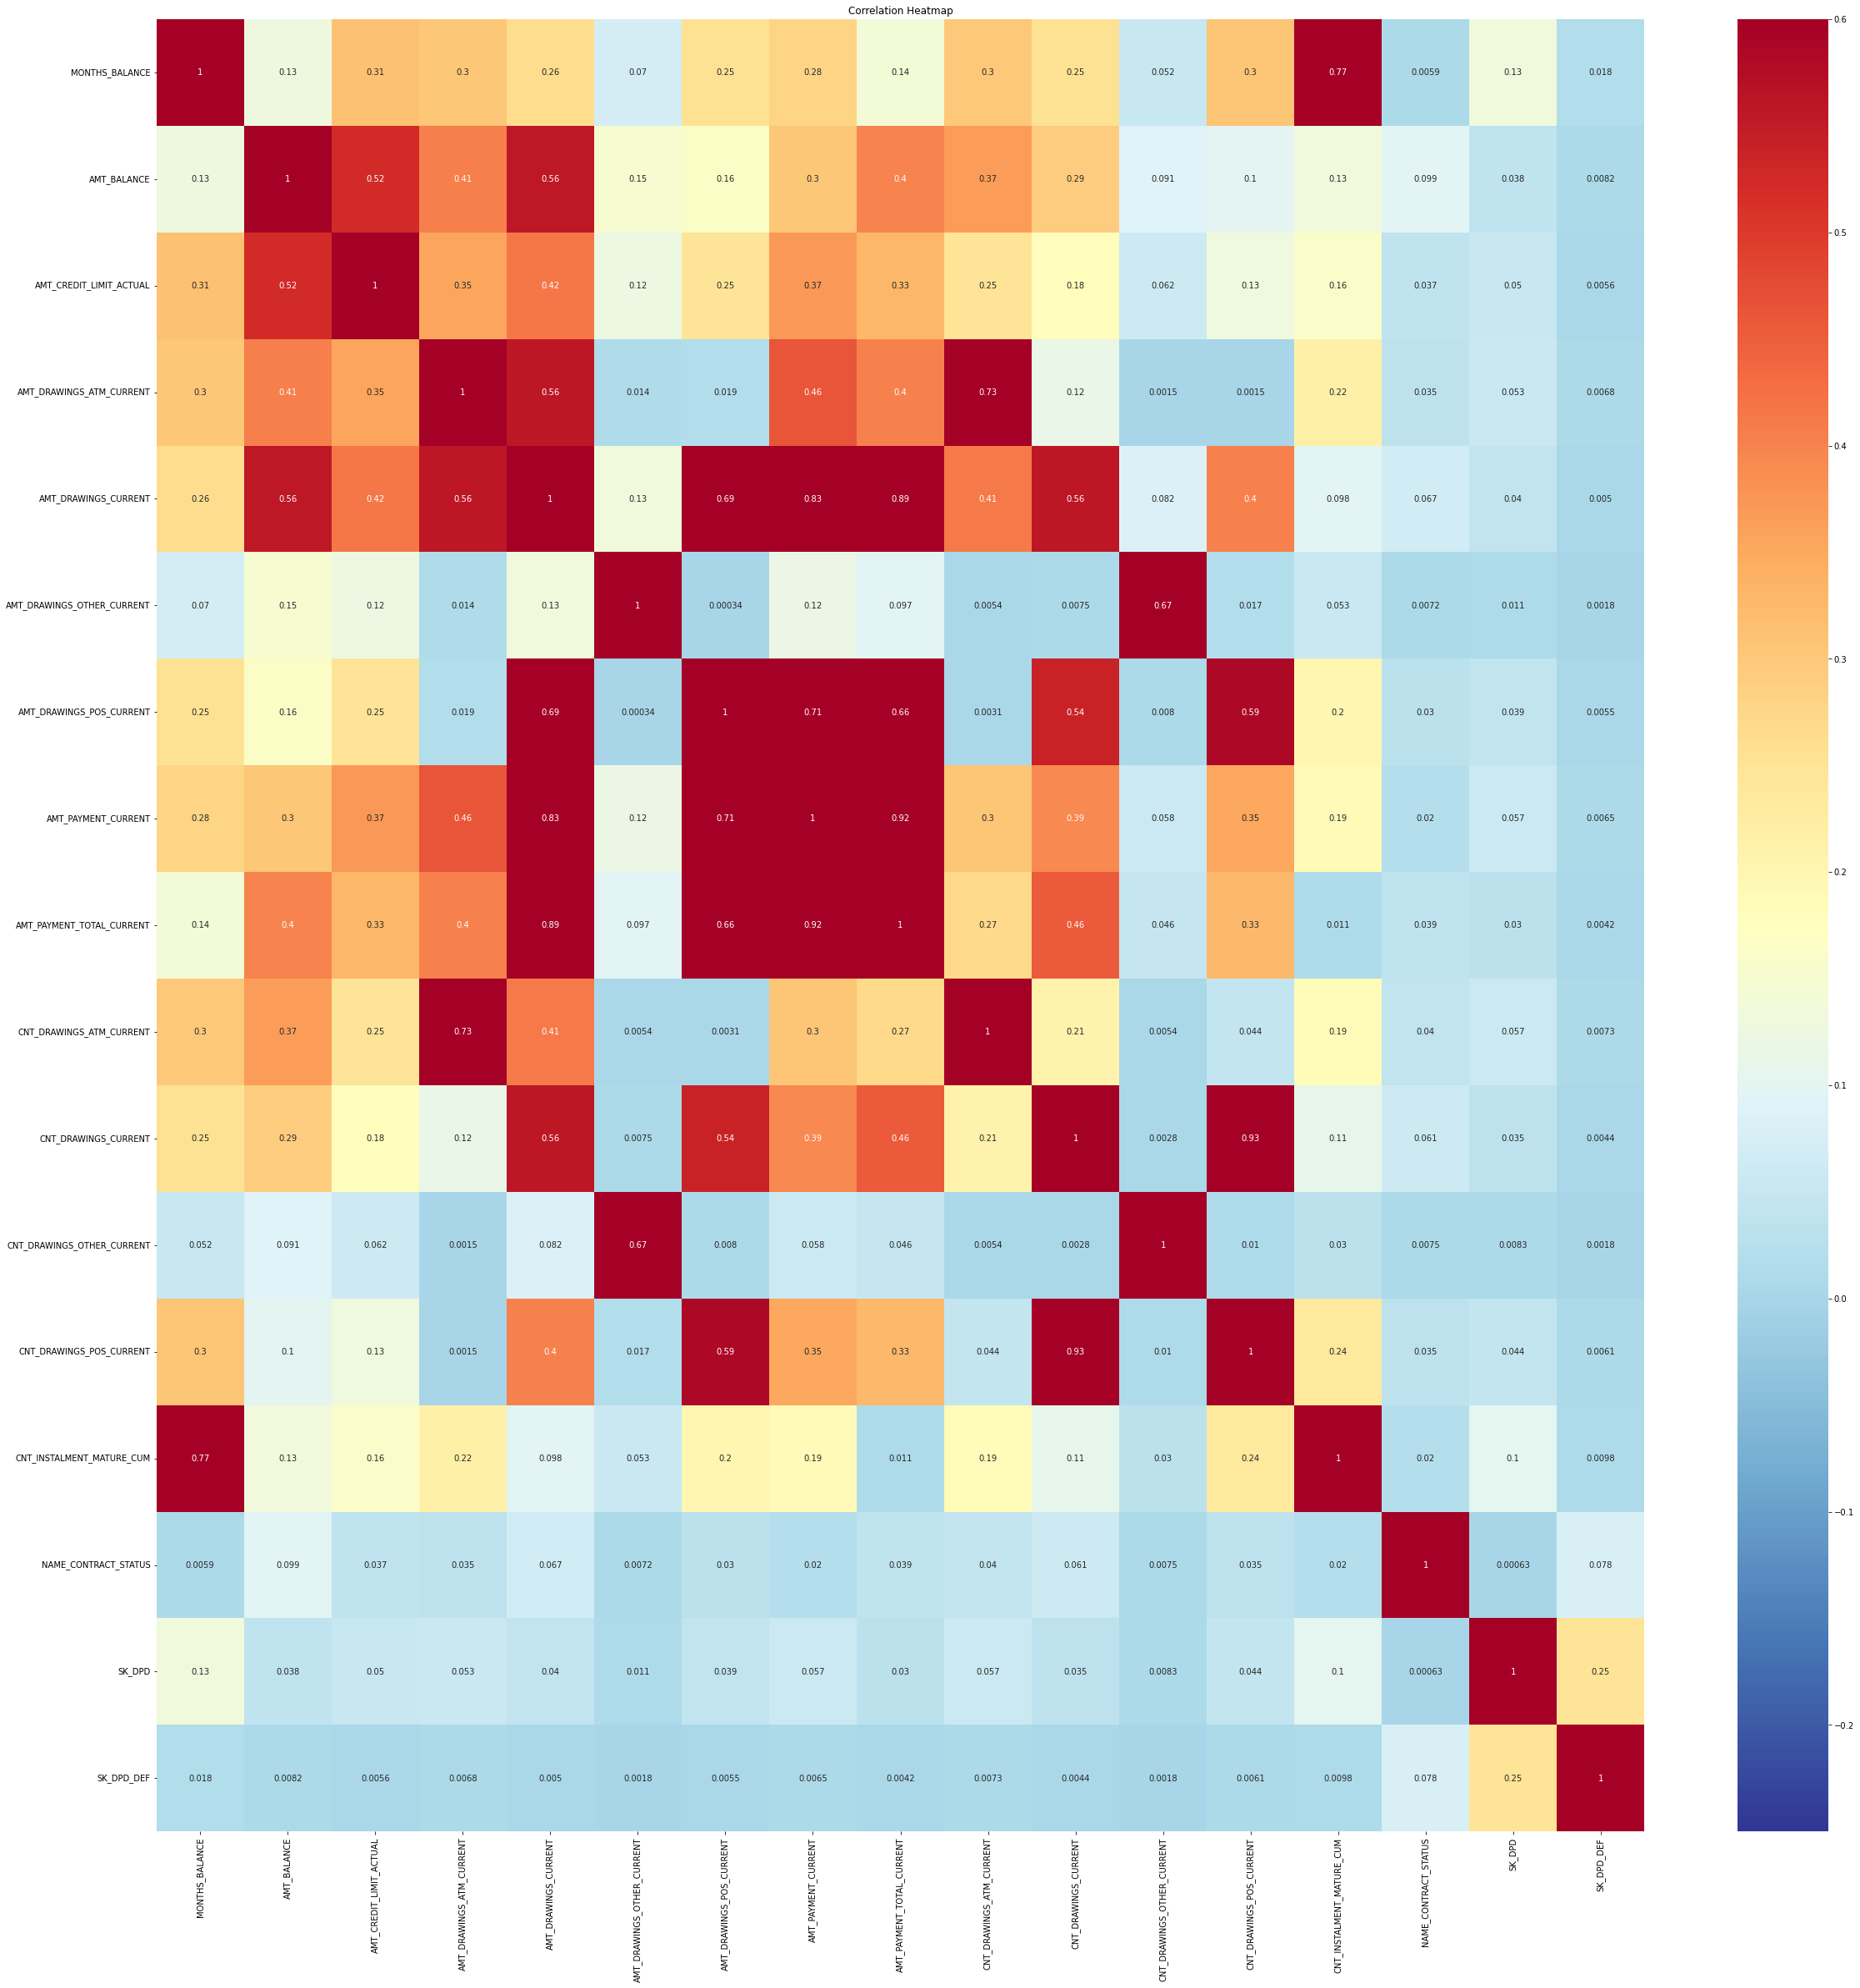

In [49]:
ccb = extra_data_pipeline(ccb_df)

In [50]:
ccb.head()

MONTHS_BALANCE   AMT_BALANCE  AMT_CREDIT_LIMIT_ACTUAL  \
SK_ID_CURR                                                          
100006                -3.5      0.000000            270000.000000   
100011               -38.5  54482.111149            164189.189189   
100013               -48.5  18159.919219            131718.750000   
100021               -10.0      0.000000            675000.000000   
100023                -7.5      0.000000            135000.000000   

            AMT_DRAWINGS_ATM_CURRENT  AMT_DRAWINGS_CURRENT  \
SK_ID_CURR                                                   
100006                  12018.179117              0.000000   
100011                   2432.432432           2432.432432   
100013                   6350.000000           5953.125000   
100021                  12018.179117              0.000000   
100023                  12018.179117              0.000000   

            AMT_DRAWINGS_OTHER_CURRENT  AMT_DRAWINGS_POS_CURRENT  \
SK_ID_CURR                                                         
100006                      583.772133               8389.181213   
100011                        0.000000                  0.000000   
100013                        0.000000                  0.000000   
100021                      583.772133               8389.181213   
100023                      583.772133               8389.181213   

            AMT_PAYMENT_CURRENT  AMT_PAYMENT_TOTAL_CURRENT  \
SK_ID_CURR                                                   
100006             17934.678567                   0.000000   
100011              4843.064189                4520.067568   
100013              7168.346250                6817.172344   
100021             17934.678567                   0.000000   
100023             17934.678567                   0.000000   

            CNT_DRAWINGS_ATM_CURRENT  CNT_DRAWINGS_CURRENT  \
SK_ID_CURR                                                   
100006                      0.546925              0.000000   
100011                      0.054054              0.054054   
100013                      0.255556              0.239583   
100021                      0.546925              0.000000   
100023                      0.546925              0.000000   

            CNT_DRAWINGS_OTHER_CURRENT  CNT_DRAWINGS_POS_CURRENT  \
SK_ID_CURR                                                         
100006                         0.00701                  1.760667   
100011                         0.00000                  0.000000   
100013                         0.00000                  0.000000   
100021                         0.00701                  1.760667   
100023                         0.00701                  1.760667   

            CNT_INSTALMENT_MATURE_CUM  NAME_CONTRACT_STATUS    SK_DPD  \
SK_ID_CURR                                                              
100006                       0.000000              0.000000  0.000000   
100011                      25.767123              0.000000  0.000000   
100013                      18.719101              0.000000  0.010417   
100021                       0.000000              1.176471  0.000000   
100023                       0.000000              0.000000  0.000000   

            SK_DPD_DEF  
SK_ID_CURR              
100006        0.000000  
100011        0.000000  
100013        0.010417  
100021        0.000000  
100023        0.000000

In [52]:
ccb.to_csv('Credit_Card_Balance.csv')

Text(0.5, 1.0, 'Correlation Heatmap')

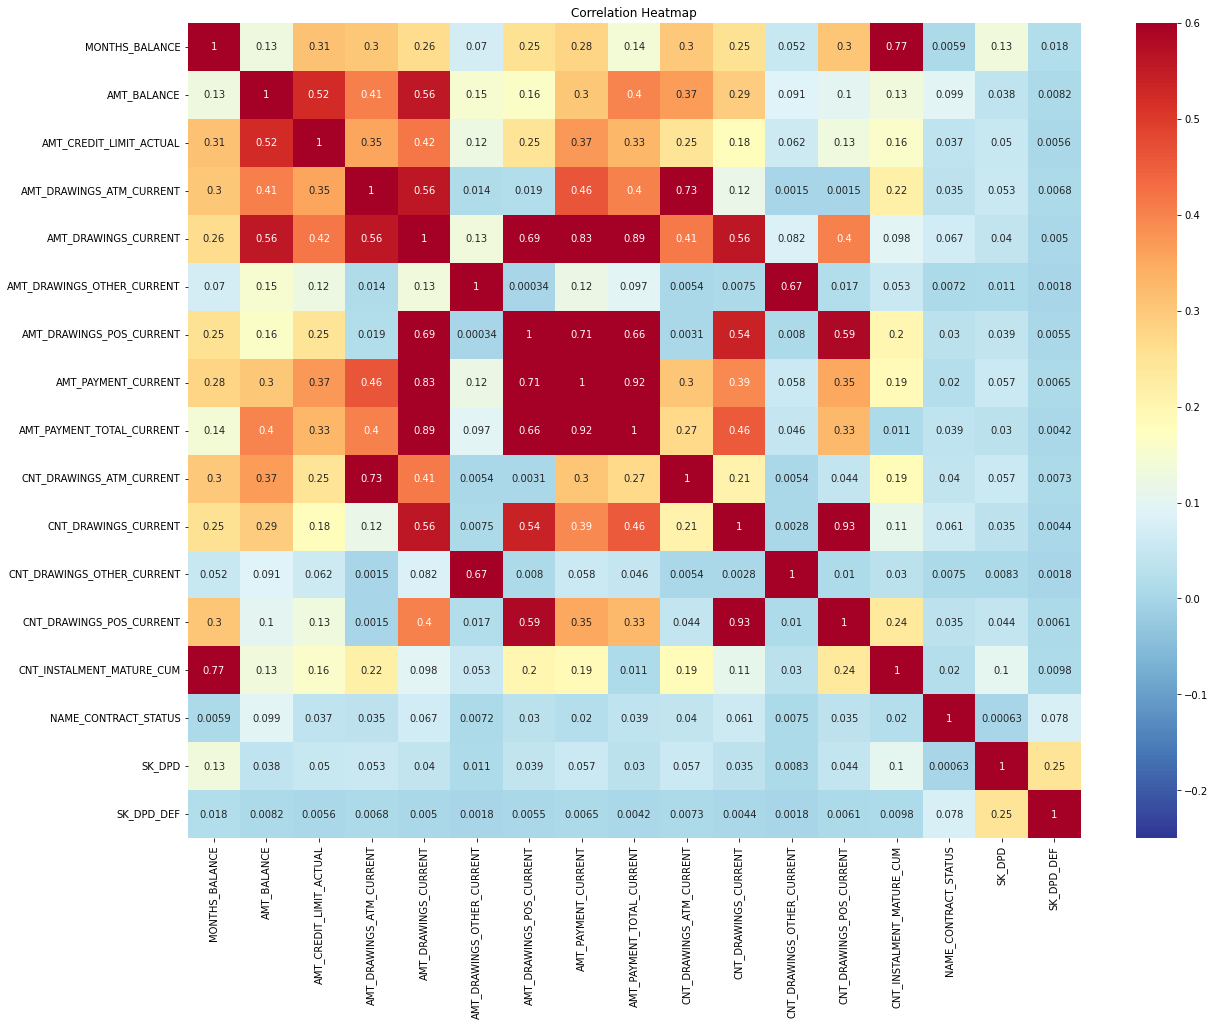

In [53]:
plt.figure(figsize=(20,15))

ccb_corr = ccb.corr().abs()
sns.heatmap(ccb_corr, cmap=plt.cm.RdYlBu_r, vmin=-0.25, annot=True, vmax=0.6)
plt.title('Correlation Heatmap')

## Installments Payments

In [54]:
desc=description_df[description_df['Table']=='installments_payments.csv'][['Row', 'Description']]
for i in range(len(desc)):
    print(desc.iloc[i]['Row'] +str(" : ")+ desc.iloc[i]['Description'])
    print()

SK_ID_PREV  : ID of previous credit in Home credit related to loan in our sample. (One loan in our sample can have 0,1,2 or more previous loans in Home Credit)

SK_ID_CURR : ID of loan in our sample

NUM_INSTALMENT_VERSION : Version of installment calendar (0 is for credit card) of previous credit. Change of installment version from month to month signifies that some parameter of payment calendar has changed

NUM_INSTALMENT_NUMBER : On which installment we observe payment

DAYS_INSTALMENT : When the installment of previous credit was supposed to be paid (relative to application date of current loan)

DAYS_ENTRY_PAYMENT : When was the installments of previous credit paid actually (relative to application date of current loan)

AMT_INSTALMENT : What was the prescribed installment amount of previous credit on this installment

AMT_PAYMENT : What the client actually paid on previous credit on this installment



In [55]:
ip_df.describe()

SK_ID_CURR  NUM_INSTALMENT_VERSION  NUM_INSTALMENT_NUMBER  \
count  339587.000000           339587.000000          339587.000000   
mean   278154.892278                1.047498               9.830926   
std    102880.492598                0.620751              11.405171   
min    100001.000000                0.000000               1.000000   
25%    189042.500000                1.000000               4.560000   
50%    278238.000000                1.018519               6.045455   
75%    367315.500000                1.111111               9.500000   
max    456255.000000               39.000000             144.208145   

       DAYS_INSTALMENT  AMT_INSTALMENT  
count    339587.000000    3.395870e+05  
mean       -910.742831    1.861577e+04  
std         598.571280    2.346509e+04  
min       -2922.000000    0.000000e+00  
25%       -1302.113085    7.897470e+03  
50%        -794.967742    1.272616e+04  
75%        -421.000000    2.164516e+04  
max          -3.000000    2.504590e+06

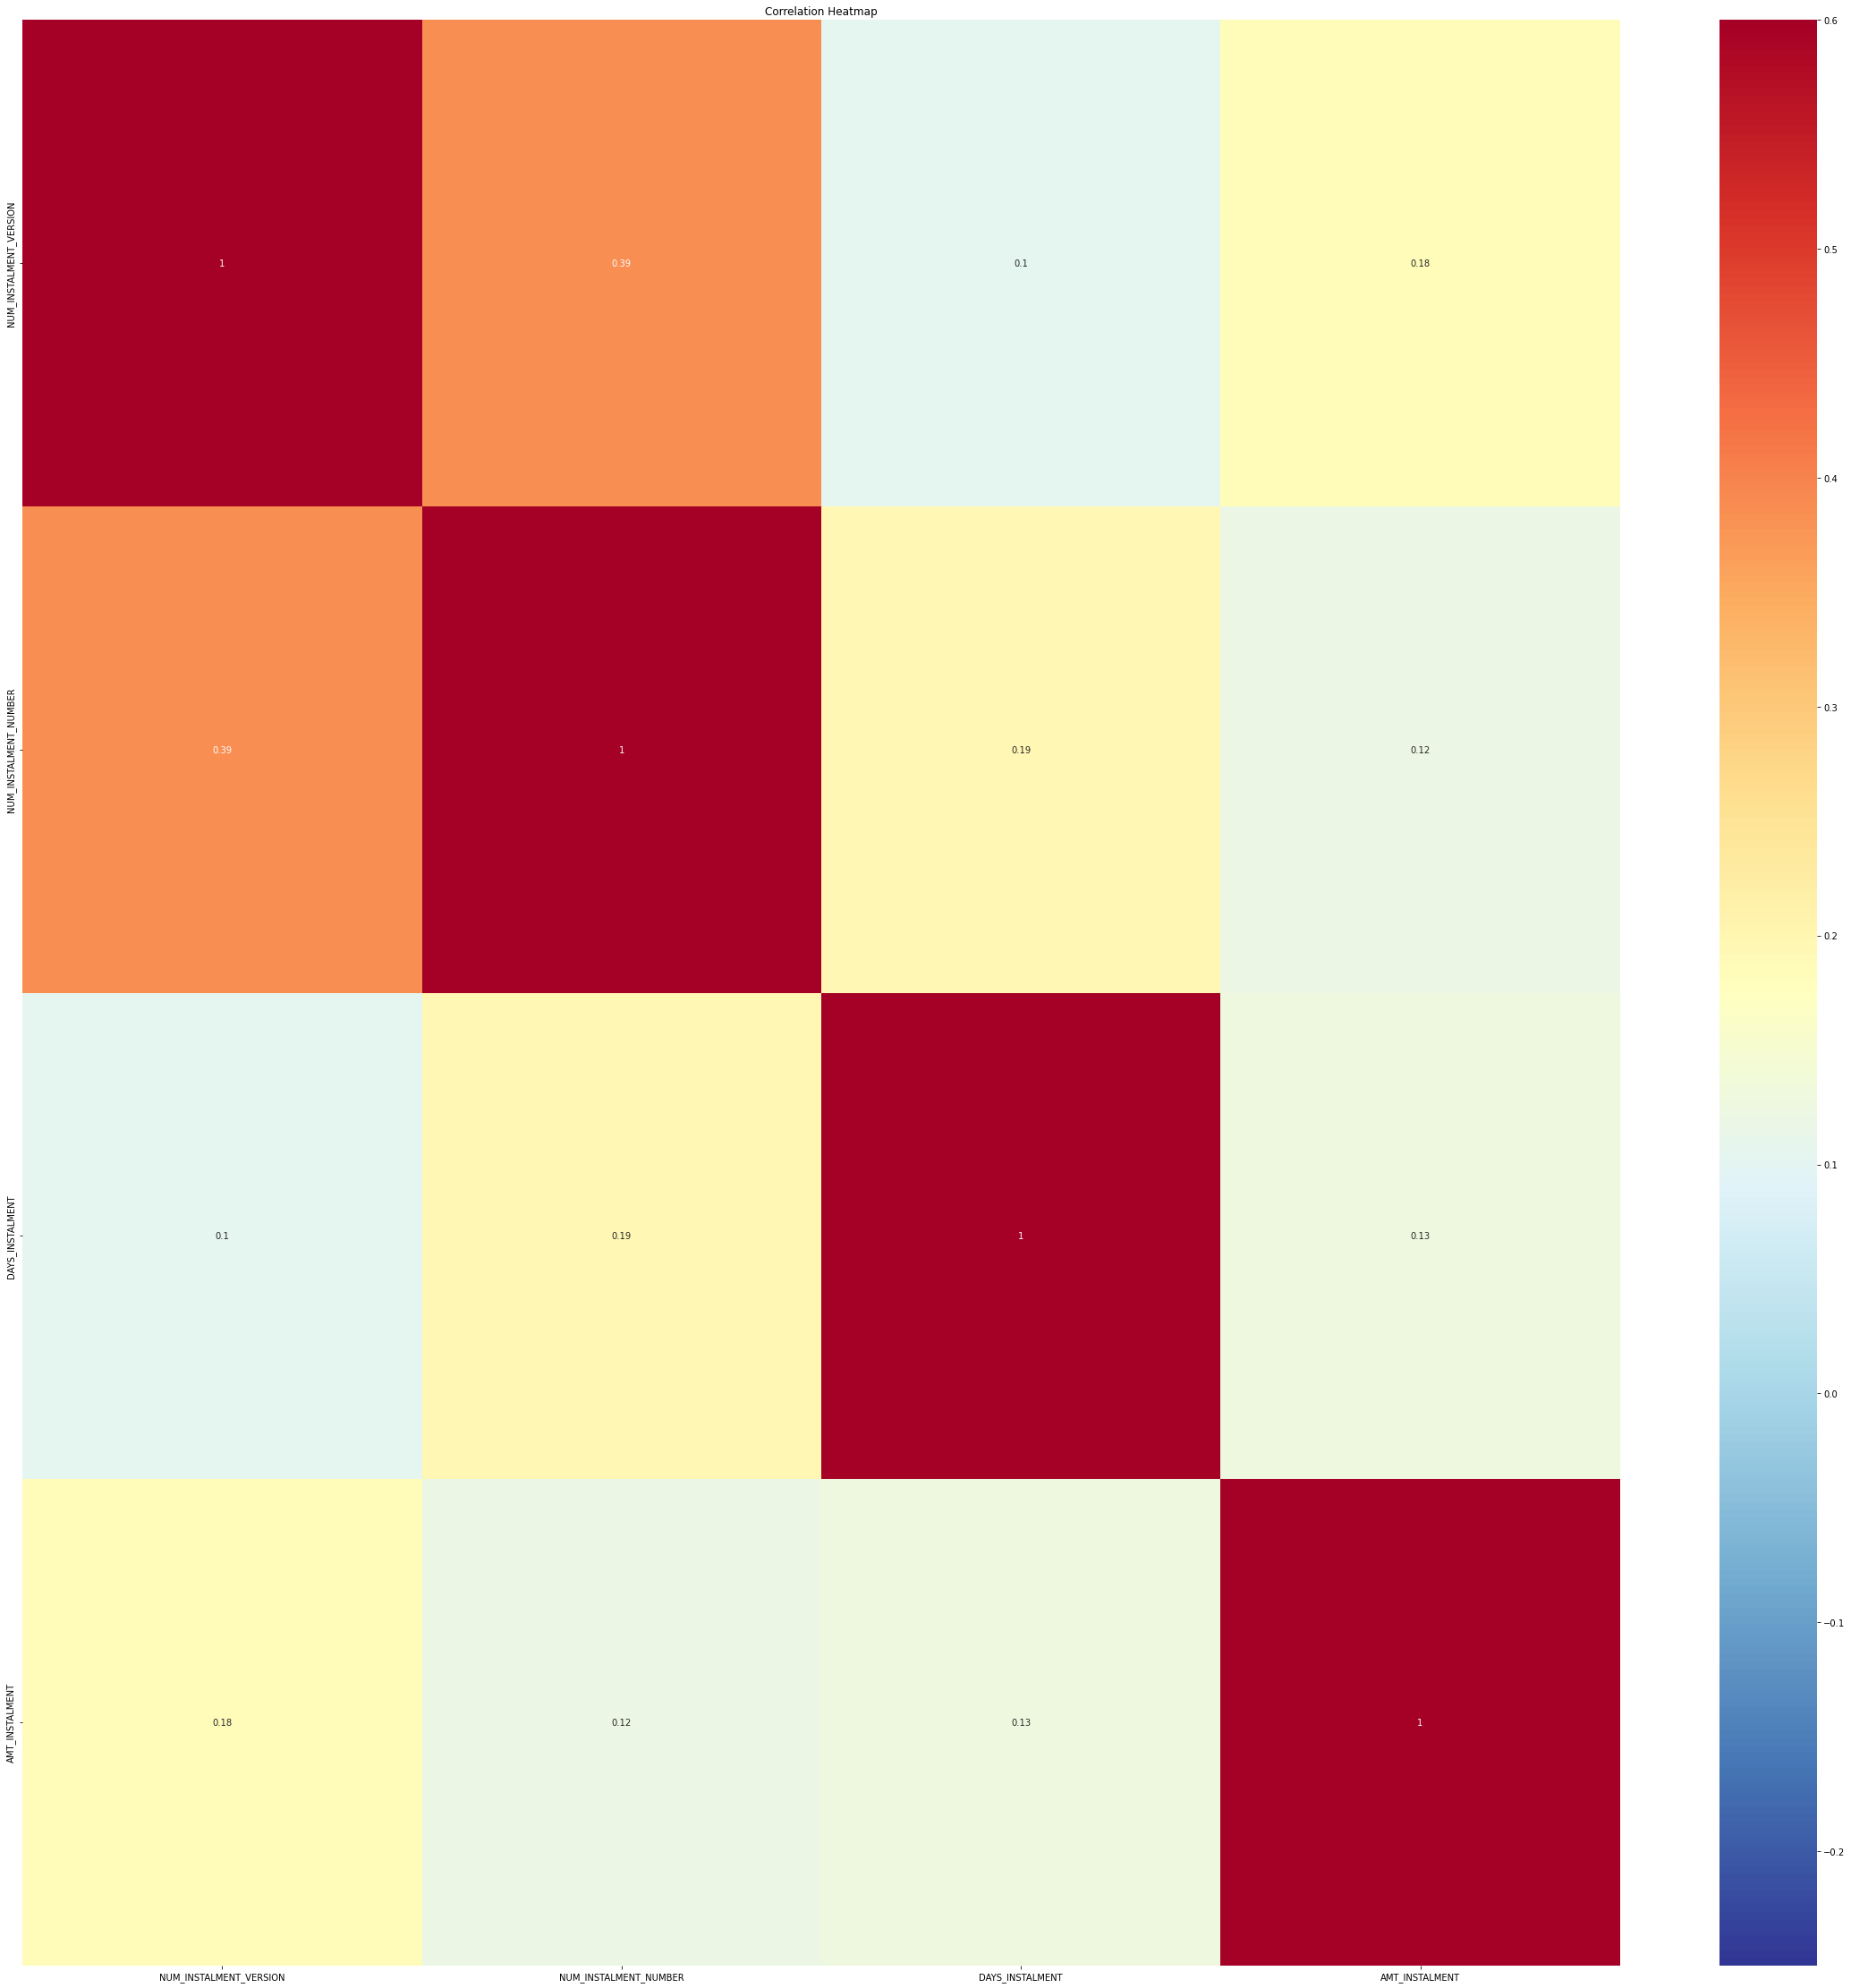

In [56]:
ip = extra_data_pipeline(ip_df)

In [57]:
ip.head()

NUM_INSTALMENT_VERSION  NUM_INSTALMENT_NUMBER  DAYS_INSTALMENT  \
SK_ID_CURR                                                                   
100001                    1.142857               2.714286     -2187.714286   
100002                    1.052632              10.000000      -295.000000   
100003                    1.040000               5.080000     -1378.160000   
100004                    1.333333               2.000000      -754.000000   
100005                    1.111111               5.000000      -586.000000   

            AMT_INSTALMENT  
SK_ID_CURR                  
100001         5885.132143  
100002        11559.247105  
100003        64754.586000  
100004         7096.155000  
100005         6240.205000

In [58]:
ip.to_csv('Installments_Payments.csv')

Text(0.5, 1.0, 'Correlation Heatmap')

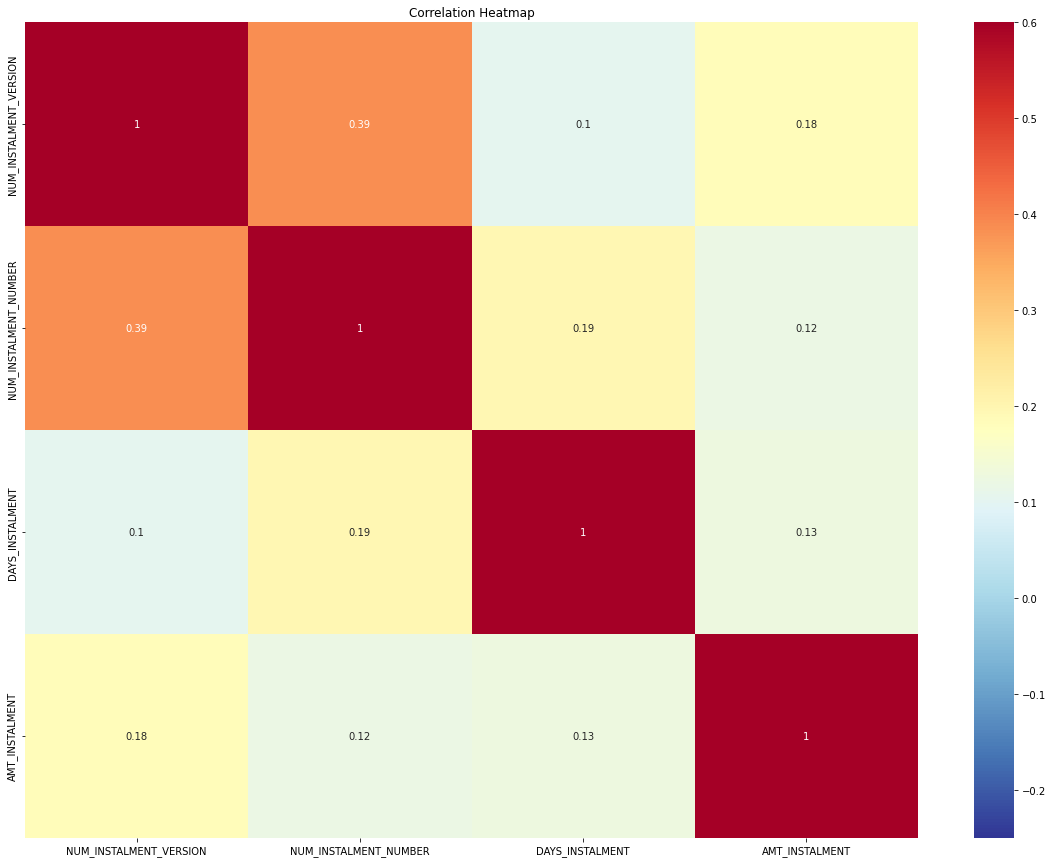

In [59]:
plt.figure(figsize=(20,15))

ip_corr=ip.corr().abs()
sns.heatmap(ip_corr, cmap=plt.cm.RdYlBu_r, vmin=-0.25, annot=True, vmax=0.6)
plt.title('Correlation Heatmap')

## Previous Application

In [60]:
pa_df.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  AMT_ANNUITY  AMT_APPLICATION  \
0      100001            1.000000     3951.000         24835.50   
1      100002            1.000000     9251.775        179055.00   
2      100003            0.666667    56553.990        435436.50   
3      100004            1.000000     5357.250         24282.00   
4      100005            0.500000     4813.200         22308.75   

   AMT_GOODS_PRICE  WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
0          24835.5                    0.000000                13.000000   
1         179055.0                    2.000000                 9.000000   
2         435436.5                    1.666667                14.666667   
3          24282.0                    0.000000                 5.000000   
4          44617.5                    2.000000                10.500000   

   FLAG_LAST_APPL_PER_CONTRACT  NFLAG_LAST_APPL_IN_DAY  \
0                          1.0                     1.0   
1                          1.0                     1.0   
2                          1.0                     1.0   
3                          1.0                     1.0   
4                          1.0                     1.0   

   NAME_CASH_LOAN_PURPOSE  NAME_CONTRACT_STATUS  DAYS_DECISION  \
0               23.000000                   0.0        -1740.0   
1               23.000000                   0.0         -606.0   
2               23.333333                   0.0        -1305.0   
3               23.000000                   0.0         -815.0   
4               23.500000                   0.5         -536.0   

   NAME_PAYMENT_TYPE  CODE_REJECT_REASON  NAME_CLIENT_TYPE  \
0                0.0                 7.0          1.000000   
1                3.0                 7.0          0.000000   
2                1.0                 7.0          1.333333   
3                0.0                 7.0          0.000000   
4                1.5                 7.0          1.000000   

   NAME_GOODS_CATEGORY  NAME_PORTFOLIO  NAME_PRODUCT_TYPE  CHANNEL_TYPE  \
0                 19.0        3.000000           0.000000      4.000000   
1                 25.0        3.000000           0.000000      7.000000   
2                 15.0        2.666667           0.666667      5.333333   
3                 19.0        3.000000           0.000000      6.000000   
4                 23.0        3.500000           0.000000      4.500000   

   SELLERPLACE_AREA  NAME_SELLER_INDUSTRY  CNT_PAYMENT  NAME_YIELD_GROUP  \
0              23.0              2.000000          8.0          1.000000   
1             500.0              0.000000         24.0          3.000000   
2             533.0              6.333333         10.0          3.666667   
3              30.0              2.000000          4.0          4.000000   
4              18.0              6.000000         12.0          0.500000   

   PRODUCT_COMBINATION  
0                 13.0  
1                 15.0  
2                  9.0  
3                 14.0  
4                  7.5

In [61]:
desc = description_df[description_df['Table']=='previous_application.csv'][['Row', 'Description']]
for i in range(len(desc)):
    print(desc.iloc[i]['Row'] +str(" : ")+ desc.iloc[i]['Description'])
    print()

SK_ID_PREV  : ID of previous credit in Home credit related to loan in our sample. (One loan in our sample can have 0,1,2 or more previous loan applications in Home Credit, previous application could, but not necessarily have to lead to credit) 

SK_ID_CURR : ID of loan in our sample

NAME_CONTRACT_TYPE : Contract product type (Cash loan, consumer loan [POS] ,...) of the previous application

AMT_ANNUITY : Annuity of previous application

AMT_APPLICATION : For how much credit did client ask on the previous application

AMT_CREDIT : Final credit amount on the previous application. This differs from AMT_APPLICATION in a way that the AMT_APPLICATION is the amount for which the client initially applied for, but during our approval process he could have received different amount - AMT_CREDIT

AMT_DOWN_PAYMENT : Down payment on the previous application

AMT_GOODS_PRICE : Goods price of good that client asked for (if applicable) on the previous application

WEEKDAY_APPR_PROCESS_START : On whic

In [62]:
#pa_df.drop(['SK_ID_PREV'], axis=1, inplace=True)
pa_df.describe()

SK_ID_CURR  NAME_CONTRACT_TYPE    AMT_ANNUITY  AMT_APPLICATION  \
count  338857.000000       338857.000000  338857.000000     3.388570e+05   
mean   278149.909581            0.780191   14656.028970     1.544683e+05   
std    102879.193103            0.374965   10086.704827     1.526145e+05   
min    100001.000000            0.000000       0.000000     0.000000e+00   
25%    189061.000000            0.500000    7913.610000     6.259770e+04   
50%    278221.000000            0.900000   12107.171250     1.068345e+05   
75%    367302.000000            1.000000   18477.187105     1.916936e+05   
max    456255.000000            2.666667  300425.445000     4.050000e+06   

       AMT_GOODS_PRICE  WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
count     3.388570e+05               338857.000000            338857.000000   
mean      1.953843e+05                    2.997320                12.672903   
std       1.921725e+05                    1.354847                 2.776552   
min       0.000000e+00                    0.000000                 0.000000   
25%       7.473600e+04                    2.000000                11.000000   
50%       1.307295e+05                    3.000000                12.769231   
75%       2.471010e+05                    4.000000                14.500000   
max       4.050000e+06                    6.000000                23.000000   

       FLAG_LAST_APPL_PER_CONTRACT  NFLAG_LAST_APPL_IN_DAY  \
count                338857.000000           338857.000000   
mean                      0.997018                0.997612   
std                       0.026823                0.025146   
min                       0.111111                0.000000   
25%                       1.000000                1.000000   
50%                       1.000000                1.000000   
75%                       1.000000                1.000000   
max                       1.000000                1.000000   

       NAME_CASH_LOAN_PURPOSE  NAME_CONTRACT_STATUS  DAYS_DECISION  \
count           338857.000000         338857.000000  338857.000000   
mean                23.047614              0.396768    -919.288946   
std                  1.119253              0.444739     574.658977   
min                  0.000000              0.000000   -2922.000000   
25%                 23.000000              0.000000   -1240.666667   
50%                 23.000000              0.285714    -788.250000   
75%                 23.500000              0.666667    -471.500000   
max                 24.000000              3.000000      -2.000000   

       NAME_PAYMENT_TYPE  CODE_REJECT_REASON  NAME_CLIENT_TYPE  \
count      338857.000000       338857.000000     338857.000000   
mean            0.960444            6.324584          1.206420   
std             0.895910            1.064574          0.663689   
min             0.000000            0.000000          0.000000   
25%             0.000000            5.800000          1.000000   
50%             1.000000            7.000000          1.400000   
75%             1.500000            7.000000          1.714286   
max             3.000000            8.000000          3.000000   

       NAME_GOODS_CATEGORY  NAME_PORTFOLIO  NAME_PRODUCT_TYPE   CHANNEL_TYPE  \
count        338857.000000   338857.000000      338857.000000  338857.000000   
mean             17.667175        2.710591           0.491002       4.834500   
std               6.842372        0.528459           0.496807       1.050449   
min               0.000000        0.000000           0.000000       0.000000   
25%              13.000000        2.428571           0.000000       4.000000   
50%              19.000000        3.000000           0.428571       4.800000   
75%              23.000000        3.000000           0.857143       5.375000   
max              27.000000        4.000000           2.000000       7.000000   

       SELLERPLACE_AREA  NAME_SELLER_INDUSTRY    CNT_PAYMENT  \
count      3.388570e+05         338857.0000

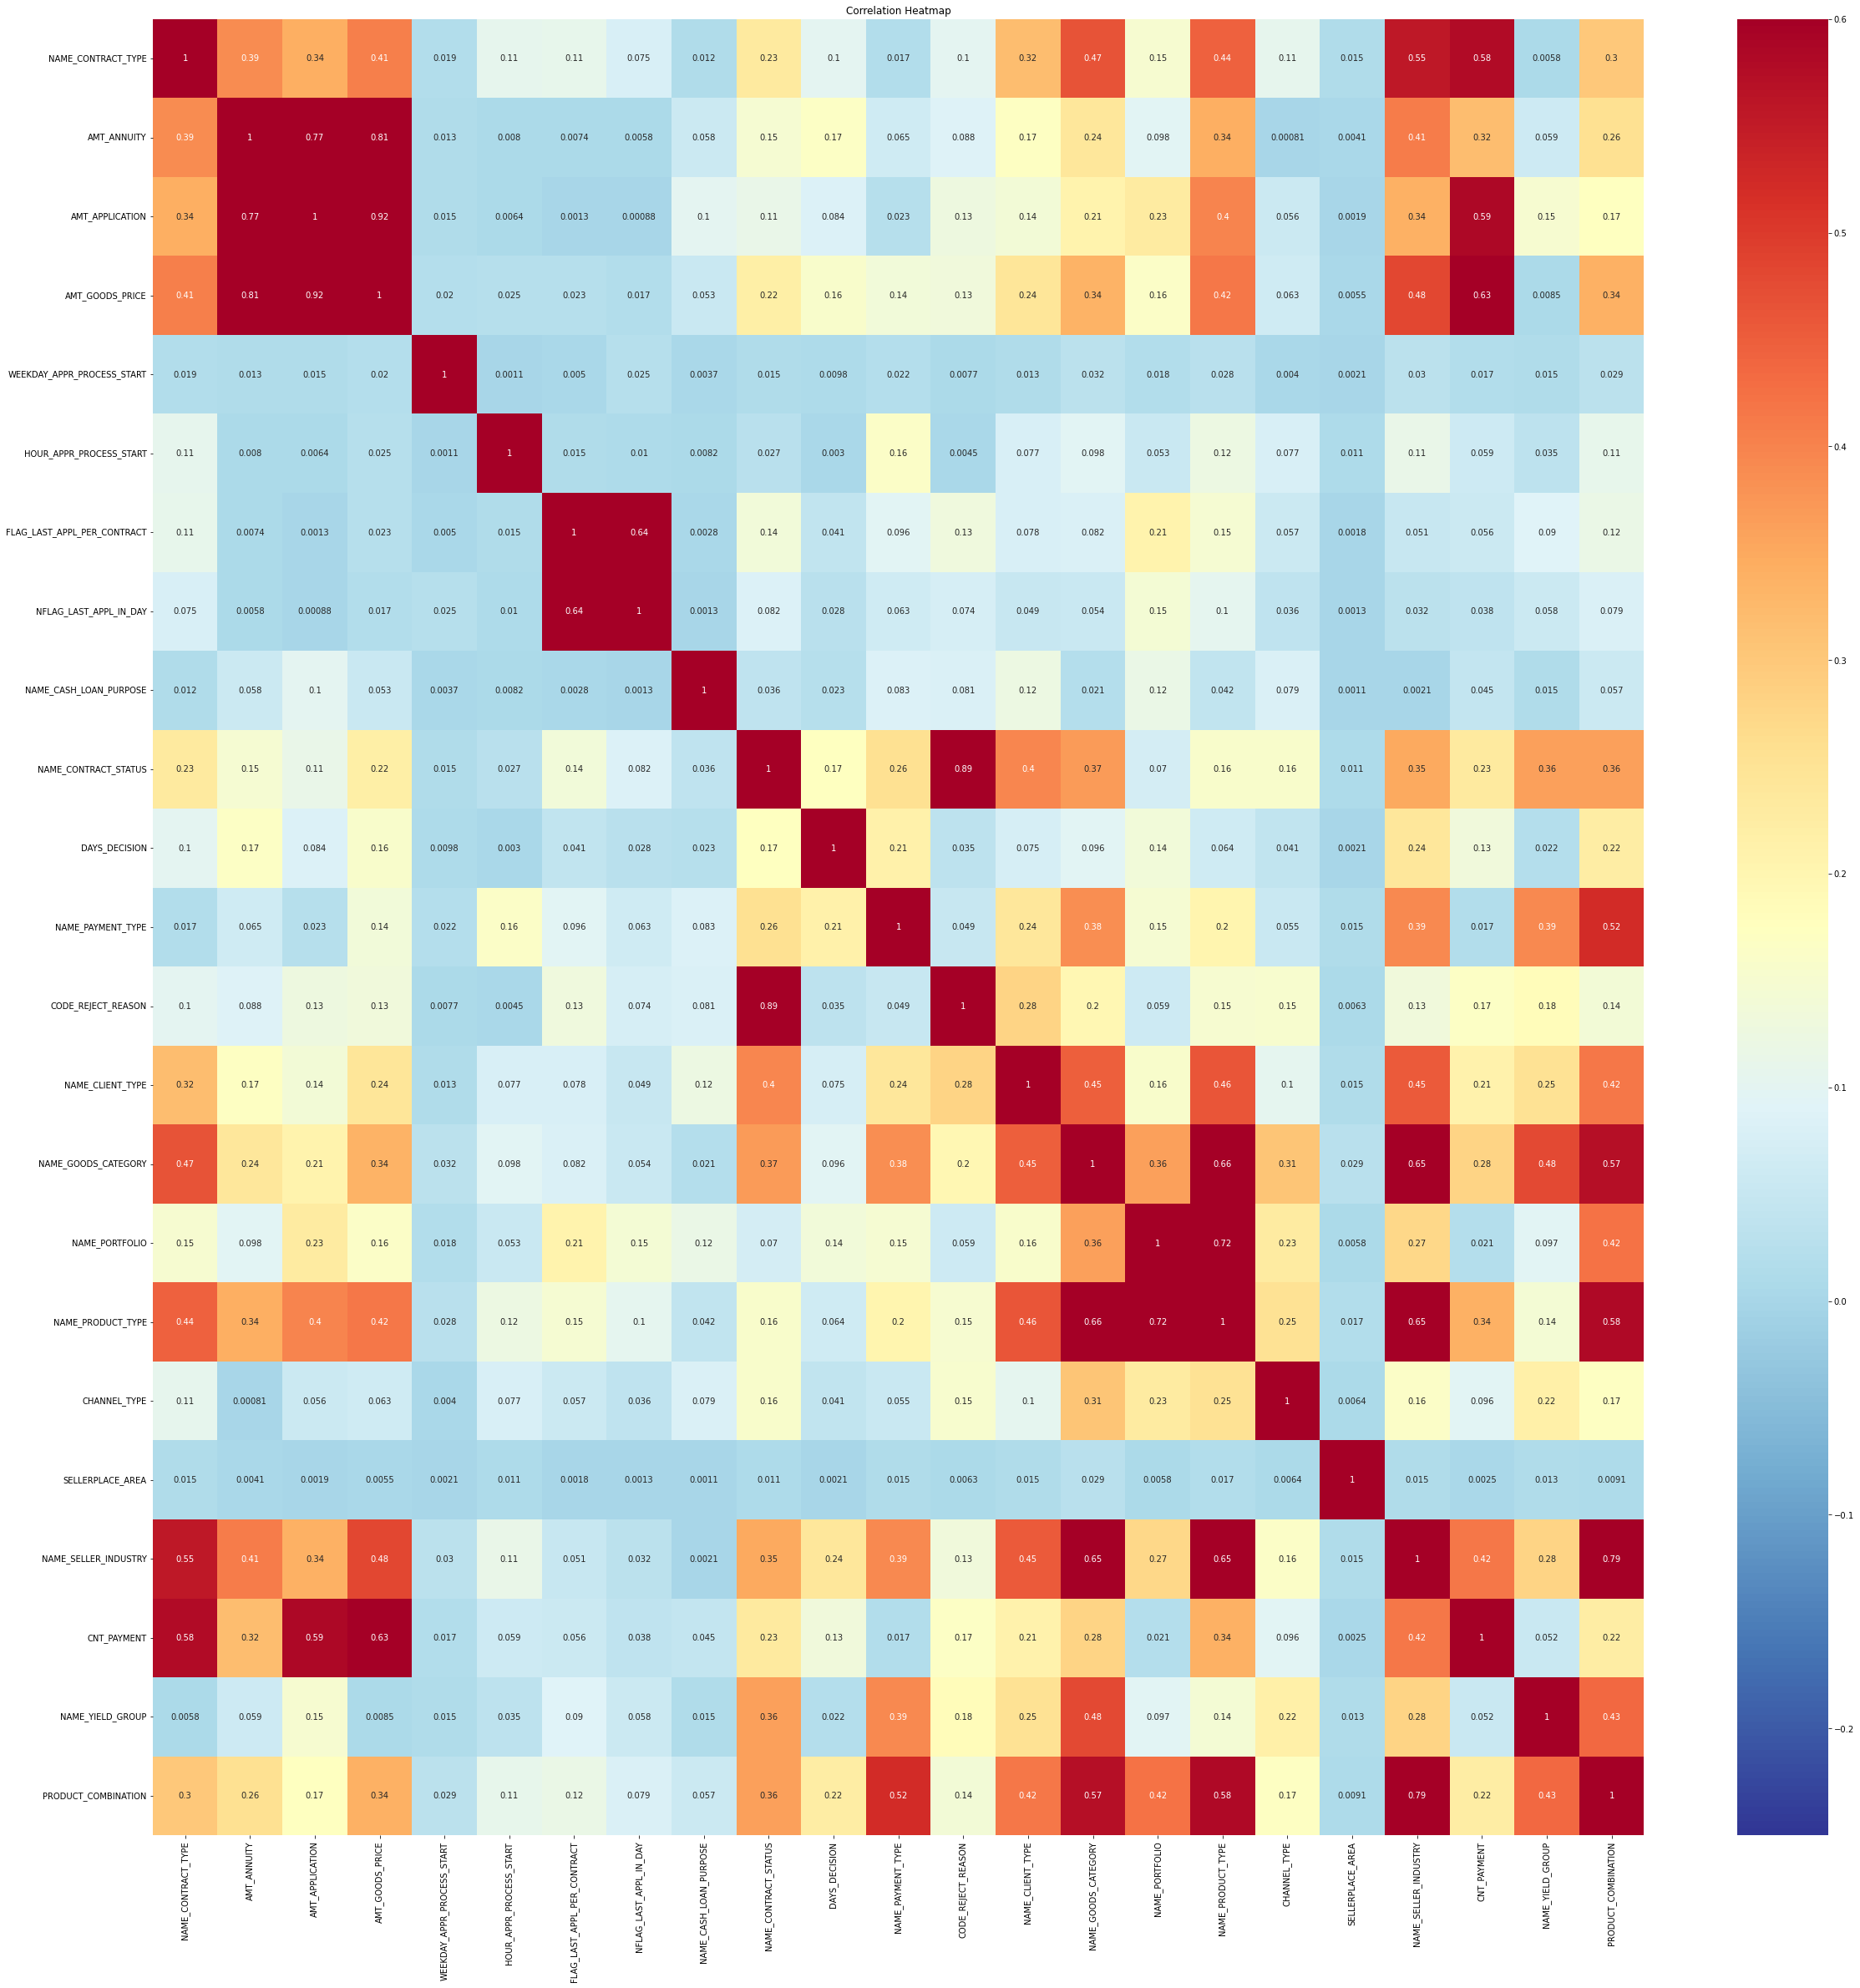

In [64]:
pa = extra_data_pipeline(pa_df)

In [65]:
pa.head()

NAME_CONTRACT_TYPE  AMT_ANNUITY  AMT_APPLICATION  AMT_GOODS_PRICE  \
SK_ID_CURR                                                                      
100001                1.000000     3951.000         24835.50          24835.5   
100002                1.000000     9251.775        179055.00         179055.0   
100003                0.666667    56553.990        435436.50         435436.5   
100004                1.000000     5357.250         24282.00          24282.0   
100005                0.500000     4813.200         22308.75          44617.5   

            WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
SK_ID_CURR                                                        
100001                        0.000000                13.000000   
100002                        2.000000                 9.000000   
100003                        1.666667                14.666667   
100004                        0.000000                 5.000000   
100005                        2.000000                10.500000   

            FLAG_LAST_APPL_PER_CONTRACT  NFLAG_LAST_APPL_IN_DAY  \
SK_ID_CURR                                                        
100001                              1.0                     1.0   
100002                              1.0                     1.0   
100003                              1.0                     1.0   
100004                              1.0                     1.0   
100005                              1.0                     1.0   

            NAME_CASH_LOAN_PURPOSE  NAME_CONTRACT_STATUS  DAYS_DECISION  \
SK_ID_CURR                                                                
100001                   23.000000                   0.0        -1740.0   
100002                   23.000000                   0.0         -606.0   
100003                   23.333333                   0.0        -1305.0   
100004                   23.000000                   0.0         -815.0   
100005                   23.500000                   0.5         -536.0   

            NAME_PAYMENT_TYPE  CODE_REJECT_REASON  NAME_CLIENT_TYPE  \
SK_ID_CURR                                                            
100001                    0.0                 7.0          1.000000   
100002                    3.0                 7.0          0.000000   
100003                    1.0                 7.0          1.333333   
100004                    0.0                 7.0          0.000000   
100005                    1.5                 7.0          1.000000   

            NAME_GOODS_CATEGORY  NAME_PORTFOLIO  NAME_PRODUCT_TYPE  \
SK_ID_CURR                                                           
100001                     19.0        3.000000           0.000000   
100002                     25.0        3.000000           0.000000   
100003                     15.0        2.666667           0.666667   
100004                     19.0        3.000000           0.000000   
100005                     23.0        3.500000           0.000000   

            CHANNEL_TYPE  SELLERPLACE_AREA  NAME_SELLER_INDUSTRY  CNT_PAYMENT  \
SK_ID_CURR                                                                      
100001          4.000000              23.0              2.000000          8.0   
100002          7.000000             500.0              0.000000         24.0   
100003          5.333333             533.0              6.333333         10.0   
100004          6.000000              30.0              2.000000          4.0   
100005          4.500000              18.0              6.000000         12.0   

            NAME_YIELD_GROUP  PRODUCT_COMBINATION  
SK_ID_CURR                                         
100001              1.000000                 13.0  
100002              3.000000                 15.0  
100003              3.666667                  9.0  
100004              4.000000                 14.0  
100005              0.500000                  7.5

In [67]:
pa.to_csv('Previous_Application.csv')

Text(0.5, 1.0, 'Correlation Heatmap')

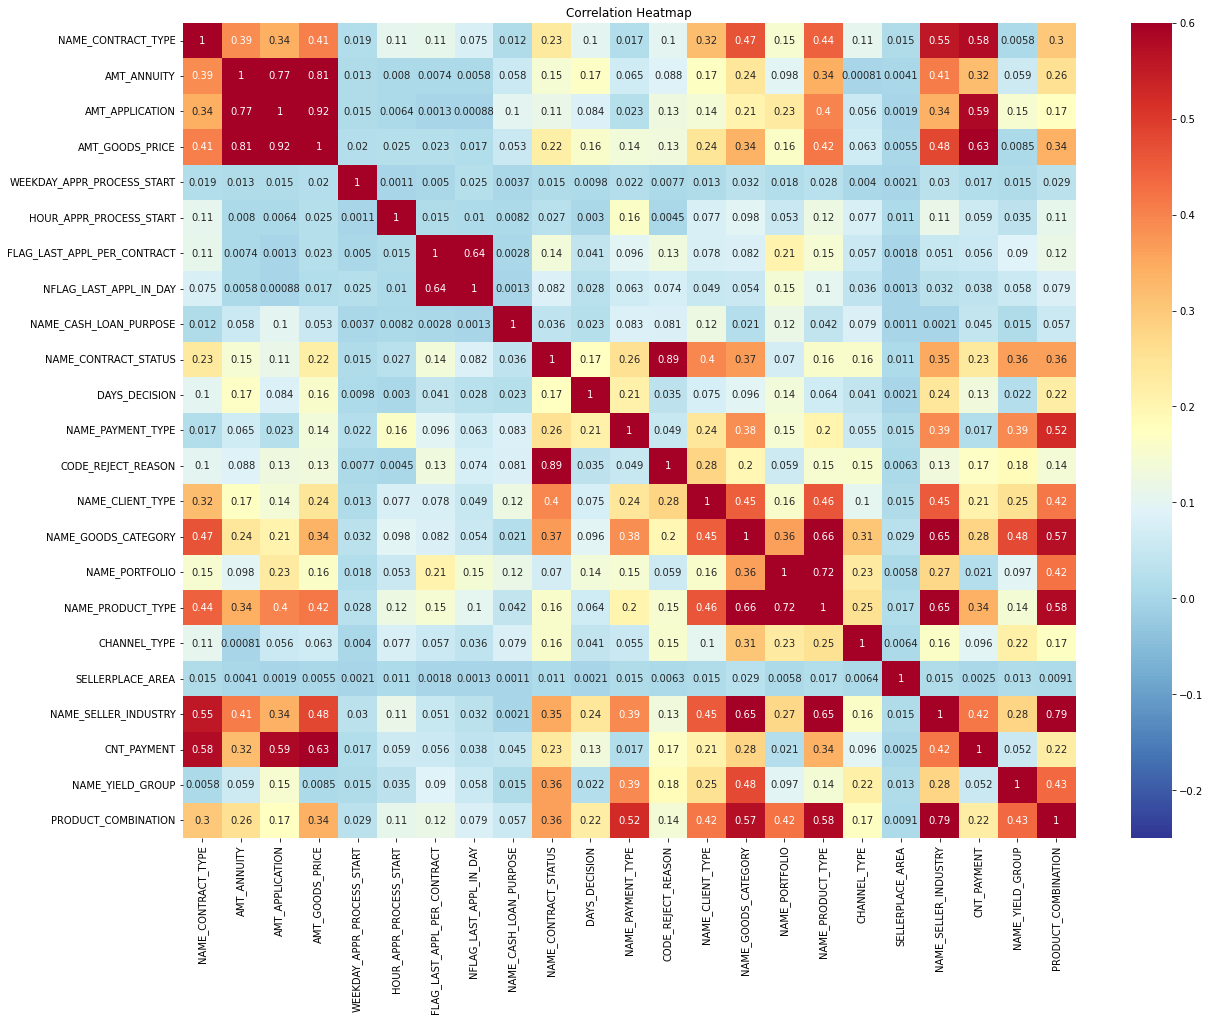

In [68]:
plt.figure(figsize=(20,15))

pa_corr=pa.corr().abs()
sns.heatmap(pa_corr, cmap=plt.cm.RdYlBu_r, vmin=-0.25, annot=True, vmax=0.6)
plt.title('Correlation Heatmap')

# Preparing data for training the model

Merging test and Train datas

In [69]:
# merging data based on the train data ( Left)
train_data_use = train_data.merge(ccb,on='SK_ID_CURR', how='left')
train_data_use = train_data.merge(ip,on='SK_ID_CURR', how='left')
train_data_use = train_data.merge(pa,on='SK_ID_CURR', how='left')

In [70]:
train_data_use.shape

(307511, 91)

In [71]:
# Let us check missing values are present in train data
train_data_use.isnull().sum()

SK_ID_CURR                  0
TARGET                      0
NAME_CONTRACT_TYPE_x        0
CODE_GENDER                 0
FLAG_OWN_CAR                0
                        ...  
SELLERPLACE_AREA        16454
NAME_SELLER_INDUSTRY    16454
CNT_PAYMENT             16454
NAME_YIELD_GROUP        16454
PRODUCT_COMBINATION     16454
Length: 91, dtype: int64

The missing values are present in the train data.

In [72]:
test_data_use = test_data.merge(ccb,on='SK_ID_CURR', how='left')
test_data_use = test_data.merge(ip,on='SK_ID_CURR', how='left')
test_data_use = test_data.merge(pa,on='SK_ID_CURR', how='left')

In [73]:
# Let us check missing values are present in test data
test_data_use.isnull().sum()

SK_ID_CURR                0
NAME_CONTRACT_TYPE_x      0
CODE_GENDER               0
FLAG_OWN_CAR              0
FLAG_OWN_REALTY           0
                       ... 
SELLERPLACE_AREA        944
NAME_SELLER_INDUSTRY    944
CNT_PAYMENT             944
NAME_YIELD_GROUP        944
PRODUCT_COMBINATION     944
Length: 91, dtype: int64

In [74]:
test_data_use.drop(['SK_ID_CURR'], axis=1, inplace=True)
train_data_use.drop(['SK_ID_CURR'], axis=1, inplace=True)

In [75]:
# see the alignement all the columns of each data and see remove that ones that are not the same in both 
train_labels=train_data_use['TARGET']

print('Training Features shape: ', train_data_use.shape)
print('Testing Features shape: ', test_data_use.shape)

Training Features shape:  (307511, 90)
Testing Features shape:  (48744, 90)


In [76]:
#### the infinity problem coulb from this

In [77]:
train_data_use['AMT_CREDIT_PERCENT'] = train_data_use['AMT_CREDIT'].astype('float')/train_data_use['AMT_INCOME_TOTAL'].astype('float')
train_data_use['AMT_APPLICATION_PERCENT'] = train_data_use['AMT_CREDIT'].astype('float')/train_data_use['AMT_APPLICATION'].astype('float')
train_data_use['AMT_GOODS_PRICE_PERCENT'] = train_data_use['AMT_CREDIT'].astype('float')/train_data_use['AMT_GOODS_PRICE'].astype('float')

In [78]:
# train_data_use['AMT_CREDIT_PERCENT']=round(train_data_use['AMT_CREDIT_PERCENT'], 2)
# train_data_use['AMT_APPLICATION_PERCENT']=round(train_data_use['AMT_APPLICATION_PERCENT'], 2)
# train_data_use['AMT_GOODS_PRICE_PERCENT']=round(train_data_use['AMT_GOODS_PRICE_PERCENT'], 2)

train_data_use.replace([np.inf, -np.inf], np.nan, inplace=True)
# train_data_use = train_data_use.fillna(0)

In [79]:
test_data_use['AMT_CREDIT_PERCENT'] = test_data_use['AMT_CREDIT'].astype('float')/test_data_use['AMT_INCOME_TOTAL'].astype('float')
test_data_use['AMT_APPLICATION_PERCENT'] = test_data_use['AMT_CREDIT'].astype('float')/test_data_use['AMT_APPLICATION'].astype('float')
test_data_use['AMT_GOODS_PRICE_PERCENT'] = test_data_use['AMT_CREDIT'].astype('float')/test_data_use['AMT_GOODS_PRICE'].astype('float')

In [80]:
# test_data_use['AMT_CREDIT_PERCENT']=round(train_data_use['AMT_CREDIT_PERCENT'], 2)
# test_data_use['AMT_APPLICATION_PERCENT']=round(train_data_use['AMT_APPLICATION_PERCENT'], 2)
# test_data_use['AMT_GOODS_PRICE_PERCENT']=round(train_data_use['AMT_GOODS_PRICE_PERCENT'], 2)
test_data_use.replace([np.inf, -np.inf], np.nan, inplace=True)
# test_data_use = test_data_use.fillna(0)

In [81]:
train_data_use.drop(['ORGANIZATION_TYPE','WEEKDAY_APPR_PROCESS_START_y','HOUR_APPR_PROCESS_START_y','CHANNEL_TYPE',\
                    'NAME_SELLER_INDUSTRY','PRODUCT_COMBINATION'], axis=1, inplace=True)
test_data_use.drop(['ORGANIZATION_TYPE','WEEKDAY_APPR_PROCESS_START_y','HOUR_APPR_PROCESS_START_y','CHANNEL_TYPE',\
                    'NAME_SELLER_INDUSTRY','PRODUCT_COMBINATION','REGION_RATING_CLIENT_W_CITY'], axis=1, inplace=True)

In [82]:
train_data_use.shape, test_data_use.shape

((307511, 87), (48744, 86))

In [83]:
# Defining categorical & numerical columns

cat_cols = ['NAME_CONTRACT_TYPE_x','CODE_GENDER','FLAG_OWN_CAR', 'FLAG_OWN_REALTY','CNT_CHILDREN','NAME_TYPE_SUITE','NAME_INCOME_TYPE','NAME_EDUCATION_TYPE',
            'NAME_FAMILY_STATUS','NAME_HOUSING_TYPE','FLAG_MOBIL','FLAG_WORK_PHONE','FLAG_CONT_MOBILE','FLAG_PHONE','FLAG_EMAIL',
            'FLAG_EMAIL','REGION_RATING_CLIENT','WEEKDAY_APPR_PROCESS_START_x','HOUR_APPR_PROCESS_START_x','REG_REGION_NOT_LIVE_REGION','REG_REGION_NOT_WORK_REGION','LIVE_REGION_NOT_WORK_REGION','REG_CITY_NOT_LIVE_CITY','REG_CITY_NOT_WORK_CITY',
            'LIVE_CITY_NOT_WORK_CITY','FLAG_DOCUMENT_2','FLAG_DOCUMENT_3','FLAG_DOCUMENT_4','FLAG_DOCUMENT_5','FLAG_DOCUMENT_6','FLAG_DOCUMENT_7','FLAG_DOCUMENT_8','FLAG_DOCUMENT_9',
             'FLAG_DOCUMENT_10','FLAG_DOCUMENT_11','FLAG_DOCUMENT_12','FLAG_DOCUMENT_13','FLAG_DOCUMENT_14','FLAG_DOCUMENT_15',
            'FLAG_DOCUMENT_16','FLAG_DOCUMENT_17','FLAG_DOCUMENT_18','FLAG_DOCUMENT_19','FLAG_DOCUMENT_20','FLAG_DOCUMENT_21','FLAG_LAST_APPL_PER_CONTRACT','NAME_CONTRACT_TYPE_y',
            'NFLAG_LAST_APPL_IN_DAY']

num_cols = ['AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY_x','REGION_POPULATION_RELATIVE','DAYS_BIRTH','DAYS_EMPLOYED','DAYS_REGISTRATION',
            'DAYS_ID_PUBLISH','CNT_FAM_MEMBERS','EXT_SOURCE_2','EXT_SOURCE_3','OBS_30_CNT_SOCIAL_CIRCLE','DEF_30_CNT_SOCIAL_CIRCLE','DEF_60_CNT_SOCIAL_CIRCLE','DAYS_LAST_PHONE_CHANGE','AMT_REQ_CREDIT_BUREAU_HOUR',
            'AMT_REQ_CREDIT_BUREAU_DAY','AMT_REQ_CREDIT_BUREAU_WEEK','AMT_REQ_CREDIT_BUREAU_MON','AMT_REQ_CREDIT_BUREAU_QRT','AMT_REQ_CREDIT_BUREAU_YEAR','AMT_ANNUITY_y','AMT_APPLICATION','AMT_GOODS_PRICE',
            'NAME_CASH_LOAN_PURPOSE','NAME_CONTRACT_STATUS','DAYS_DECISION','NAME_PAYMENT_TYPE','CODE_REJECT_REASON','NAME_CLIENT_TYPE','NAME_GOODS_CATEGORY','NAME_PORTFOLIO','NAME_PRODUCT_TYPE','SELLERPLACE_AREA',
            'CNT_PAYMENT','NAME_YIELD_GROUP','AMT_CREDIT_PERCENT','AMT_APPLICATION_PERCENT','AMT_GOODS_PRICE_PERCENT']


print(f"Number of categorical columns: {len(cat_cols)}")
print(f"Number of numerical columns: {len(num_cols)}")

Number of categorical columns: 48
Number of numerical columns: 39


In [84]:
# To get target classes

train_data_use['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

In [85]:
# Splitting the dataset

# Data for training
x = train_data_use.drop(['TARGET'],axis=1)
y = train_data_use['TARGET']

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)


In [86]:
# Creating column transformer to select all column names that has Binary & a list for non Binary.

# Define categorical pipeline for imputing the missing values
cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

# Define numerical pipeline for imputing the missing values
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler())
])

# Combine categorical and numerical pipelines for column transformer
preprocessor = ColumnTransformer([
    ('cat', cat_pipe, cat_cols),
    ('num', num_pipe, num_cols)
])


# Finding best model to use for this case

# DummyClassifier
 https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html
 

# Logistic Regression Model

In [87]:
# Create a pipeline for preprocessor & logistic regression
lr = LogisticRegression(C=1.0,penalty='l2')#  remove (C=1.0,penalty='l2') because grid search will set the parameters it will automaticaly  ause penatly ="l2"

lr_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', lr)
])

In [88]:
# Fitting the model

lr_pipe.fit(x_train, y_train)######### remove this because we are fitting by random

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['NAME_CONTRACT_TYPE_x',
                                                   'CODE_GENDER',
                                                   'FLAG_OWN_CAR',
                                                   'FLAG_OWN_REALTY',
                                                   'CNT_CHILDREN',
                                                   'NAME_TYPE_SUITE',
                                                   'NAME_INCOME_TYPE',
                                                   'NAME_EDUCATION_TYPE',
                                                   'NAME_FAMILY_STATUS',
                                                   'NAME_HOUSING_TYPE',
                

In [89]:
# Model performance on test data
lr_pred = lr_pipe.predict(x_test)###### delete this because we have removed the Fit above so it will no longer work 
lr_pred

array([0, 0, 0, ..., 0, 0, 0])

Data is imbalanced so accuracy is not a good metric for this kind of data. We are going to use other metrics as follows.

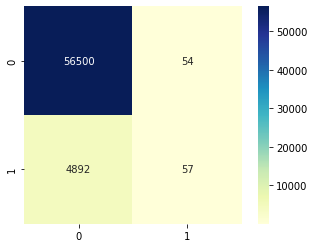

In [ ]:
# Confusion Matrix  ###### delete this because we have removed the Fit above so it will no longer work 
cm = confusion_matrix(y_test, lr_pred)
cm_matrix = pd.DataFrame(data=cm, columns=[0, 1], index=[0,1])

sns.heatmap(cm_matrix, square=True, annot=True, fmt='d', cmap='YlGnBu')

In [90]:
# Classification report ###### delete this because we have removed the Fit above so it will no longer work 
print(classification_report(y_test, lr_pred))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56554
           1       0.51      0.01      0.02      4949

    accuracy                           0.92     61503
   macro avg       0.71      0.51      0.49     61503
weighted avg       0.89      0.92      0.88     61503



In [92]:
print(fbeta_score(y_test, lr_pred, beta = 0.5))

0.052807115063924395


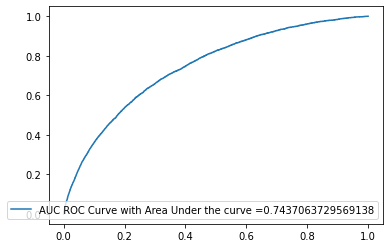

In [93]:
# To get area under curve score ###### delete this because we have removed the Fit above so it will no longer work 
generate_auc_roc_curve(lr_pipe, x_test)

AUC score for logistic regression is 0.743. We try to improve it by applying other algorithms.

In [94]:
# Applying the Grid Search CV on Logistic regression &  kfold on (to make the process faster)

x_train_60 = x_train[:int(len(x_train)*0.6)]# just put Xtrain 
y_train_60 = y_train[:int(len(y_train)*0.6)]# just put ytrain
# only one hyper parameter tuning for logistic regression
params={"C":[0.001, 0.1, 1.0]}# l1 lasso l2 ridge
cv = KFold(n_splits=5, random_state=1, shuffle=True)
lr_grid = GridSearchCV(lr, params, cv=cv, scoring='roc_auc')

lr_grid_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', lr_grid)
])

lr_grid_pipe.fit(x_train_60,y_train_60)##### do it witht best 




##### 

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['NAME_CONTRACT_TYPE_x',
                                                   'CODE_GENDER',
                                                   'FLAG_OWN_CAR',
                                                   'FLAG_OWN_REALTY',
                                                   'CNT_CHILDREN',
                                                   'NAME_TYPE_SUITE',
                                                   'NAME_INCOME_TYPE',
                                                   'NAME_EDUCATION_TYPE',
                                                   'NAME_FAMILY_STATUS',
                                                   'NAME_HOUSING_TYPE',
                

In [95]:
print("tuned hpyerparameters :(best parameters) ",lr_grid.best_params_)
print("AUC score :",lr_grid.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 0.1}
AUC score : 0.7426369169436976


In [96]:
# Grid search - logistic model performance on test data
lr_grid_pred = lr_grid_pipe.predict(x_test)
lr_grid_pred

array([0, 0, 0, ..., 0, 0, 0])

<AxesSubplot:>

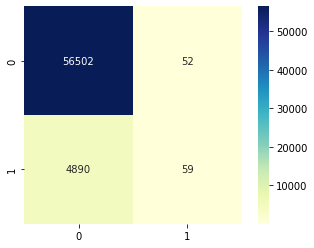

In [97]:
# Confusion Matrix
cm = confusion_matrix(y_test, lr_grid_pred)
cm_matrix = pd.DataFrame(data=cm, columns=[0, 1], index=[0,1])

sns.heatmap(cm_matrix, square=True, annot=True, fmt='d', cmap='YlGnBu')

In [98]:
# Classification report
print(classification_report(y_test, lr_grid_pred))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56554
           1       0.53      0.01      0.02      4949

    accuracy                           0.92     61503
   macro avg       0.73      0.51      0.49     61503
weighted avg       0.89      0.92      0.88     61503



In [99]:
print(fbeta_score(y_test, lr_grid_pred, beta = 0.5))

0.05470053773409976


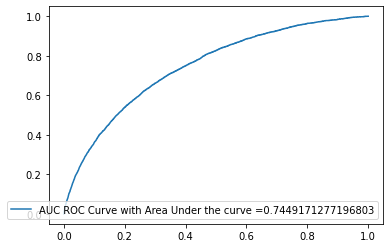

In [100]:
# To get area under curve score
generate_auc_roc_curve(lr_grid_pipe, x_test)

# Over Sampling

 Over sampler SMOTE 

In [101]:
from imblearn.pipeline import Pipeline
# Create a pipeline for preprocessor & logistic regression with smote
lr_sm = LogisticRegression(C=1.0,penalty='l2') ###### delete the C and penalty because this is only for c 1 and we have another one below with hyper parameter

lr_sm_pipe = Pipeline([
    ('preprocessor', preprocessor),('sampling', SMOTE(random_state=42)),
    ('model', lr_sm)
])


In [102]:
# Fitting the model   ###### delete the C and penalty because this is only for c 1 and we have another one below with hyper parameter

lr_sm_pipe.fit(x_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['NAME_CONTRACT_TYPE_x',
                                                   'CODE_GENDER',
                                                   'FLAG_OWN_CAR',
                                                   'FLAG_OWN_REALTY',
                                                   'CNT_CHILDREN',
                                                   'NAME_TYPE_SUITE',
                                                   'NAME_INCOME_TYPE',
                                                   'NAME_EDUCATION_TYPE',
                                                   'NAME_FAMILY_STATUS',
                                                   'NAME_HOUSING_TYPE',
                

In [103]:
# Model performance on test data  ###### delete the C and penalty because this is only for c 1 and we have another one below with hyper parameter
lr_sm_pred = lr_sm_pipe.predict(x_test)
lr_sm_pred

array([1, 0, 1, ..., 0, 1, 0])

<AxesSubplot:>

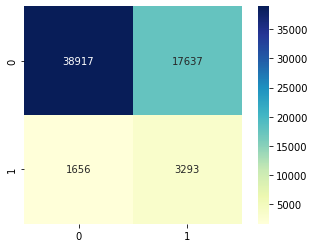

In [104]:
# Confusion Matrix  ###### delete the C and penalty because this is only for c 1 and we have another one below with hyper parameter
cm = confusion_matrix(y_test, lr_sm_pred)
cm_matrix = pd.DataFrame(data=cm, columns=[0, 1], index=[0,1])

sns.heatmap(cm_matrix, square=True, annot=True, fmt='d', cmap='YlGnBu')

In [105]:
print(fbeta_score(y_test, lr_sm_pred, beta = 0.5))

0.18569060212701172


In [106]:
# Classification report  ###### delete the C and penalty because this is only for c 1 and we have another one below with hyper parameter
print(classification_report(y_test, lr_sm_pred))

              precision    recall  f1-score   support

           0       0.96      0.69      0.80     56554
           1       0.16      0.67      0.25      4949

    accuracy                           0.69     61503
   macro avg       0.56      0.68      0.53     61503
weighted avg       0.89      0.69      0.76     61503



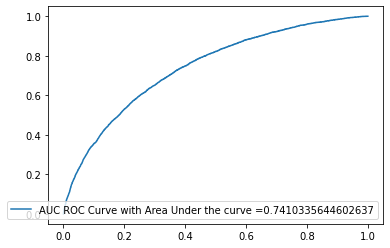

In [107]:
# To get Area under curve score  ###### delete the C and penalty because this is only for c 1 and we have another one below with hyper parameter
generate_auc_roc_curve(lr_sm_pipe, x_test)

AUC score for logistic regression with SMOTE is 0.581. It's not improve much compare to base model.

In [108]:
# Applying the Grid Search CV on Logistic regression &  kfold on 60% of 80% and 20% test
x_train_60 = x_train[:int(len(x_train)*0.6)] # just put Xtrain
y_train_60 = y_train[:int(len(y_train)*0.6)] # just put Xtrain

params={"C":[0.001, 0.1, 1.0]}# l1 lasso l2 ridge
cv = KFold(n_splits=5, random_state=1, shuffle=True)
lr_sm_grid = GridSearchCV(lr_sm, params, cv=cv, scoring='roc_auc')

lr_sm_grid_pipe = Pipeline([
    ('preprocessor', preprocessor),('sampling', SMOTE(random_state=42)),
    ('model', lr_sm_grid)
])


lr_sm_grid_pipe.fit(x_train_60,y_train_60)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['NAME_CONTRACT_TYPE_x',
                                                   'CODE_GENDER',
                                                   'FLAG_OWN_CAR',
                                                   'FLAG_OWN_REALTY',
                                                   'CNT_CHILDREN',
                                                   'NAME_TYPE_SUITE',
                                                   'NAME_INCOME_TYPE',
                                                   'NAME_EDUCATION_TYPE',
                                                   'NAME_FAMILY_STATUS',
                                                   'NAME_HOUSING_TYPE',
                

In [109]:
print("tuned hpyerparameters :(best parameters) ",lr_sm_grid.best_params_)
print("AUC score :",lr_sm_grid.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 1.0}
AUC score : 0.7624053872144664


In [110]:
# Grid search - logistic model with smote performance on test data
lr_sm_grid_pred = lr_sm_grid_pipe.predict(x_test)
lr_sm_grid_pred

array([1, 0, 1, ..., 0, 1, 0])

<AxesSubplot:>

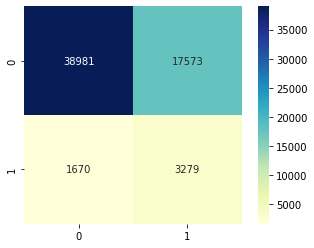

In [111]:
# Confusion Matrix
cm = confusion_matrix(y_test, lr_sm_grid_pred)
cm_matrix = pd.DataFrame(data=cm, columns=[0, 1], index=[0,1])

sns.heatmap(cm_matrix, square=True, annot=True, fmt='d', cmap='YlGnBu')

In [112]:
# Classification report
print(classification_report(y_test, lr_sm_grid_pred))

              precision    recall  f1-score   support

           0       0.96      0.69      0.80     56554
           1       0.16      0.66      0.25      4949

    accuracy                           0.69     61503
   macro avg       0.56      0.68      0.53     61503
weighted avg       0.89      0.69      0.76     61503



In [113]:
print(fbeta_score(y_test, lr_sm_grid_pred, beta = 0.5))

0.052807115063924395


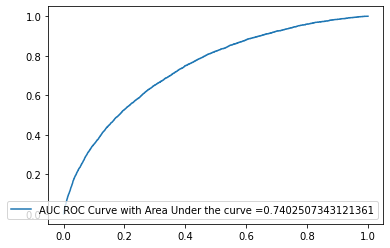

In [ ]:
# To get area under curve score
generate_auc_roc_curve(lr_sm_grid_pipe, x_test)

Over sampler RandomOverSampler   # remove it from the deliver file but keep it for personal use
# reput in pipeline with grid search we you have to use it and give it to the teacher 

In [ ]:
# # Applying RandomOverSampler to balance the data
# random = RandomOverSampler()
# x_random, y_random = random.fit_resample(x_train, y_train)

In [ ]:
# Counter(y_random)

In [ ]:
# # Applying logistic regression as base model on balanced data
# lr_random = lr.fit(x_random,y_random)

In [ ]:
# y_pred_random = lr_random.predict(x_test)
# y_pred_random

In [ ]:
# # Confusion Matrix
# cm = confusion_matrix(y_test, y_pred_random)
# cm_matrix = pd.DataFrame(data=cm, columns=[0, 1], index=[0,1])

# sns.heatmap(cm_matrix, square=True, annot=True, fmt='d', cmap='YlGnBu')

In [ ]:
# # Classification Report
# print(classification_report(y_test, y_pred_random))

In [ ]:
# # To get Area under curve score
# generate_auc_roc_curve(lr_random, x_test)

AUC score for logistic regression with RandomOverSampler is 0.582. It's not improve much compare to base model. We will try other sampling techniques.

# Under Sampling

Under sampler RandomUnderSampler

In [ ]:
# # Applying RandomUnderSampler to balance the data
# random_u = RandomUnderSampler()
# x_random_u, y_random_u = random_u.fit_resample(x_train, y_train)

In [ ]:
# Counter(y_random_u)

In [ ]:
# # Applying logistic regression as base model on balanced data
# lr_random_u = lr.fit(x_random_u,y_random_u)

In [ ]:
# y_pred_random_u = lr_random_u.predict(x_test)
# y_pred_random_u

In [ ]:
# # Confusion Matrix
# cm = confusion_matrix(y_test, y_pred_random_u)
# cm_matrix = pd.DataFrame(data=cm, columns=[0, 1], index=[0,1])

# sns.heatmap(cm_matrix, square=True, annot=True, fmt='d', cmap='YlGnBu')

In [ ]:
# # Classification Report
# print(classification_report(y_test, y_pred_random_u))

In [ ]:
# # To get Area Under Curve score
# generate_auc_roc_curve(lr_random_u, x_test)

AUC score for logistic regression with RandomUnderSampler is 0.58. It's not improve much compare to base model. We will try other sampling techniques.

Under sampler TomekLinks

In [ ]:
# # Applying Tome Links to balance the data
# tok = TomekLinks()
# x_tok, y_tok = tok.fit_resample(x_train, y_train)

In [ ]:
# Counter(y_tok)

In [ ]:
# # Applying logistic regression as base model on balanced data
# lr_tok = lr.fit(x_tok,y_tok)

In [ ]:
# y_pred_tok = lr_tok.predict(x_test)
# y_pred_tok

In [ ]:
# # Confusion Matrix
# cm = confusion_matrix(y_test, y_pred_tok)
# cm_matrix = pd.DataFrame(data=cm, columns=[0, 1], index=[0,1])

# sns.heatmap(cm_matrix, square=True, annot=True, fmt='d', cmap='YlGnBu')

In [ ]:
# # Classification Report
# print(classification_report(y_test, y_pred_tok))

In [ ]:
# # To get Area under the curve score
# generate_auc_roc_curve(lr_tok, x_test)

AUC score for logistic regression with TomekLinks is 0.614. It's not improve much compare to base model.

### Near Miss

Undersample Near Miss

In [ ]:
# # Applying TomekLinks to balance the data
# nm = NearMiss()
# x_nm, y_nm = nm.fit_resample(x_train, y_train)

In [ ]:
# Counter(y_nm)

In [ ]:
# # Applying logistic regression as base model on balanced data
# lr_nm = lr.fit(x_nm,y_nm)

In [ ]:
# y_pred_nm = lr_nm.predict(x_test)
# y_pred_nm

In [ ]:
# # Confusion Matrix
# cm = confusion_matrix(y_test, y_pred_nm)
# cm_matrix = pd.DataFrame(data=cm, columns=[0, 1], index=[0,1])

# sns.heatmap(cm_matrix, square=True, annot=True, fmt='d', cmap='YlGnBu')

In [ ]:
# # Classification Report
# print(classification_report(y_test, y_pred_nm))

In [ ]:
# # To get Area under curve score
# generate_auc_roc_curve(lr_nm, x_test)

AUC score for logistic regression with NearMiss is 0.516. It's not improve much compare to base model.

# Random Forest Classifier

In [ ]:
# Create a pipeline for preprocessor & Random Forest Classifier  #### remove this because there's no hyper paramter and we have done the same below with hyperparamter 
rf = RandomForestClassifier(random_state=42) 

rf_pipe = Pipeline([
    ('preprocessor', preprocessor),('sampling', SMOTE(random_state=42)),
    ('model', rf)
])

In [ ]:
# Fit Random Forest Pipeline model #### remove this because there's no hyper paramter and we have done the same below with hyperparamter 

rf_pipe.fit(x_train, y_train)

KeyboardInterrupt: ignored

In [ ]:
# Model performance on test data #### remove this because there's no hyper paramter and we have done the same below with hyperparamter 
rf_pred = rf_pipe.predict(x_test)
rf_pred

Data is imbalanced so accuracy is not a good metric for this kind of data. We are going to use other metrics as follows.

In [ ]:
# Confusion Matrix #### remove this because there's no hyper paramter and we have done the same below with hyperparamter 
cm = confusion_matrix(y_test, rf_pred)
cm_matrix = pd.DataFrame(data=cm, columns=[0, 1], index=[0,1])

sns.heatmap(cm_matrix, square=True, annot=True, fmt='d', cmap='YlGnBu')

In [ ]:
# Classification report #### remove this because there's no hyper paramter and we have done the same below with hyperparamter 
print(classification_report(y_test, rf_pred))

In [ ]:
# To get area under curve score #### remove this because there's no hyper paramter and we have done the same below with hyperparamter 
generate_auc_roc_curve(rf_pipe, x_test)

AUC score for random forest classifier is 0.7138.

In [ ]:
# Applying the Grid Search CV on Random forest classifier &  kfold (we made 60% to make the process faster)


#I AM HERE WITH THE TEACHER


x_train_60 = x_train[:int(len(x_train)*0.6)]  ### remoce 60 % becauser the Grid search does the work
y_train_60 = y_train[:int(len(y_train)*0.6)] ### remoce 60 % becauser the Grid search does the work

params = {
    'n_estimators': [100],### remove 10 and 50 because they are less powerfull and less better than the 100 we didn't use higher because it will take to much time to run and may not give you a better result 
    'max_depth': [8,10,12],
    'min_samples_split':[5,8,10]
}

cv = KFold(n_splits=5, random_state=1, shuffle=True)
rf_grid = GridSearchCV(rf, params, cv=cv, scoring='roc_auc')

rf_grid_pipe = lr_pipe = Pipeline([
    ('preprocessor', preprocessor),('sampling', SMOTE(random_state=42)),
    ('model', rf_grid)
])

rf_grid_pipe.fit(x_train_60,y_train_60)



#### do the same as regression logistice with over sampling (you didn't do it on this one)

In [ ]:
print("tuned hpyerparameters :(best parameters) ",rf_grid.best_params_)
print("AUC score :",rf_grid.best_score_)

tuned hpyerparameters :(best parameters)  {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 100}

AUC score : 0.7382220703479385


In [ ]:
# Grid search CV - Random forest model performance on test data
rf_grid_pred = rf_grid_pipe.predict(x_test)
rf_grid_pred

array([0, 0, 0, ..., 0, 0, 0])

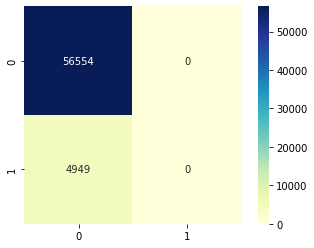

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, rf_grid_pred)
cm_matrix = pd.DataFrame(data=cm, columns=[0, 1], index=[0,1])

sns.heatmap(cm_matrix, square=True, annot=True, fmt='d', cmap='YlGnBu')

In [ ]:
# Classification report
print(classification_report(y_test, rf_grid_pred))

              precision    recall  f1-score   support



           0       0.92      1.00      0.96     56554

           1       0.00      0.00      0.00      4949



    accuracy                           0.92     61503

   macro avg       0.46      0.50      0.48     61503

weighted avg       0.85      0.92      0.88     61503




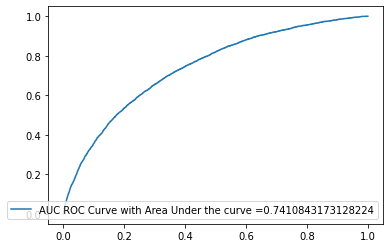

In [ ]:
# To get area under curve score
generate_auc_roc_curve(rf_grid_pipe, x_test)

# LightGBM Classifier

In [114]:
# Create a pipeline for preprocessor & LightGBM Classifier
import lightgbm as lgb
lgb = lgb.LGBMClassifier(class_weight='balanced',n_estimators=300,learning_rate=0.05) ###### class_weight='balanced this can solve the disbalance data .

lgb_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', lgb)
])

#### juste put pipeline and over sampling 



In [115]:
# Fitting LightGBM model 

lgb_pipe.fit(x_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['NAME_CONTRACT_TYPE_x',
                                                   'CODE_GENDER',
                                                   'FLAG_OWN_CAR',
                                                   'FLAG_OWN_REALTY',
                                                   'CNT_CHILDREN',
                                                   'NAME_TYPE_SUITE',
                                                   'NAME_INCOME_TYPE',
                                                   'NAME_EDUCATION_TYPE',
                                                   'NAME_FAMILY_STATUS',
                                                   'NAME_HOUSING_TYPE',
                

In [116]:
# Model performance on test data
lgb_pred = lgb_pipe.predict(x_test)
lgb_pred

array([1, 0, 1, ..., 0, 0, 0])

Data is imbalanced so accuracy is not a good metric for this kind of data. We are going to use other metrics as follows.

<AxesSubplot:>

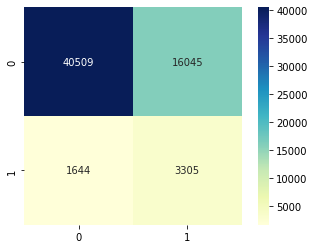

In [117]:
# Confusion Matrix
cm = confusion_matrix(y_test, lgb_pred)
cm_matrix = pd.DataFrame(data=cm, columns=[0, 1], index=[0,1])

sns.heatmap(cm_matrix, square=True, annot=True, fmt='d', cmap='YlGnBu')

In [118]:
# Classification report
print(classification_report(y_test, lgb_pred))

              precision    recall  f1-score   support

           0       0.96      0.72      0.82     56554
           1       0.17      0.67      0.27      4949

    accuracy                           0.71     61503
   macro avg       0.57      0.69      0.55     61503
weighted avg       0.90      0.71      0.78     61503



In [119]:
print(fbeta_score(y_test, lgb_pred, beta = 0.5))

0.20067031779378014


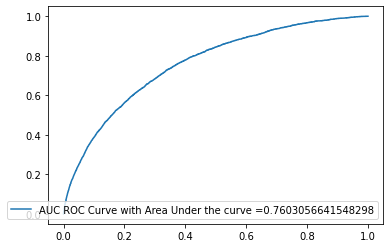

In [120]:
# To get area under curve score
generate_auc_roc_curve(lgb_pipe, x_test)

AUC score for lightgbm classifier is 0.76.


In [121]:
# Applying the Grid Search CV on LightGBM classifier &  (to go faster)
x_train_60 = x_train[:int(len(x_train)*0.6)] ## remove 60%
y_train_60 = y_train[:int(len(y_train)*0.6)] ## remove 60%

params = {
     'boosting': ['gbdt'],
    'objective': ['binary'],
    'num_iterations': [100, 200],
    'learning_rate':[0.01,0.05],
    'num_leaves':[7, 9],
    'max_depth' :[8,10],
    'bagging_fraction': [0.5, 0.7],
    'n_estimators':[300],  ##### i added this because this is better
}

cv = KFold(n_splits=5, random_state=1, shuffle=True)
lgb_grid = GridSearchCV(lgb, params, cv=cv, scoring='roc_auc')

lgb_grid_pipe = lr_pipe = Pipeline([
    ('preprocessor', preprocessor),('sampling', SMOTE(random_state=42)),
    ('model', lgb_grid)
])

# Fitting the model
lgb_grid_pipe.fit(x_train_60,y_train_60)

######### do the same as regression logistice with over sampling (you didn't do it on this one) and you need to put hyper paramter

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosti

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['NAME_CONTRACT_TYPE_x',
                                                   'CODE_GENDER',
                                                   'FLAG_OWN_CAR',
                                                   'FLAG_OWN_REALTY',
                                                   'CNT_CHILDREN',
                                                   'NAME_TYPE_SUITE',
                                                   'NAME_INCOME_TYPE',
                                                   'NAME_EDUCATION_TYPE',
                                                   'NAME_FAMILY_STATUS',
                                                   'NAME_HOUSING_TYPE',
                

In [122]:
print("tuned hpyerparameters :(best parameters) ",lgb_grid.best_params_)
print("AUC score :",lgb_grid.best_score_)

tuned hpyerparameters :(best parameters)  {'bagging_fraction': 0.5, 'boosting': 'gbdt', 'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 300, 'num_iterations': 200, 'num_leaves': 9, 'objective': 'binary'}
AUC score : 0.9746353672491772


In [123]:
# Grid search CV - LightGBM model performance on test data
lgb_grid_pred = lgb_grid_pipe.predict(x_test)
lgb_grid_pred

array([0, 0, 0, ..., 0, 0, 0])

<AxesSubplot:>

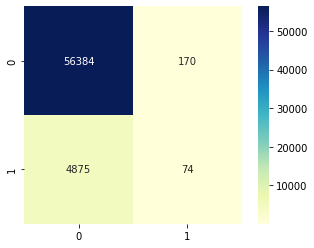

In [124]:
# Confusion Matrix
cm = confusion_matrix(y_test, lgb_grid_pred)
cm_matrix = pd.DataFrame(data=cm, columns=[0, 1], index=[0,1])
sns.heatmap(cm_matrix, square=True, annot=True, fmt='d', cmap='YlGnBu')

In [125]:
# Classification report
print(classification_report(y_test, lgb_grid_pred))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56554
           1       0.30      0.01      0.03      4949

    accuracy                           0.92     61503
   macro avg       0.61      0.51      0.49     61503
weighted avg       0.87      0.92      0.88     61503



In [131]:
print(fbeta_score(y_test, lgb_grid_pred, beta = 0.5))

0.06244725738396624


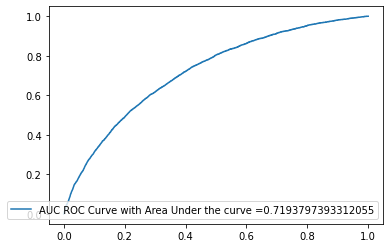

In [127]:
# To get area under curve score
generate_auc_roc_curve(lgb_grid_pipe, x_test)

# Feature Importance

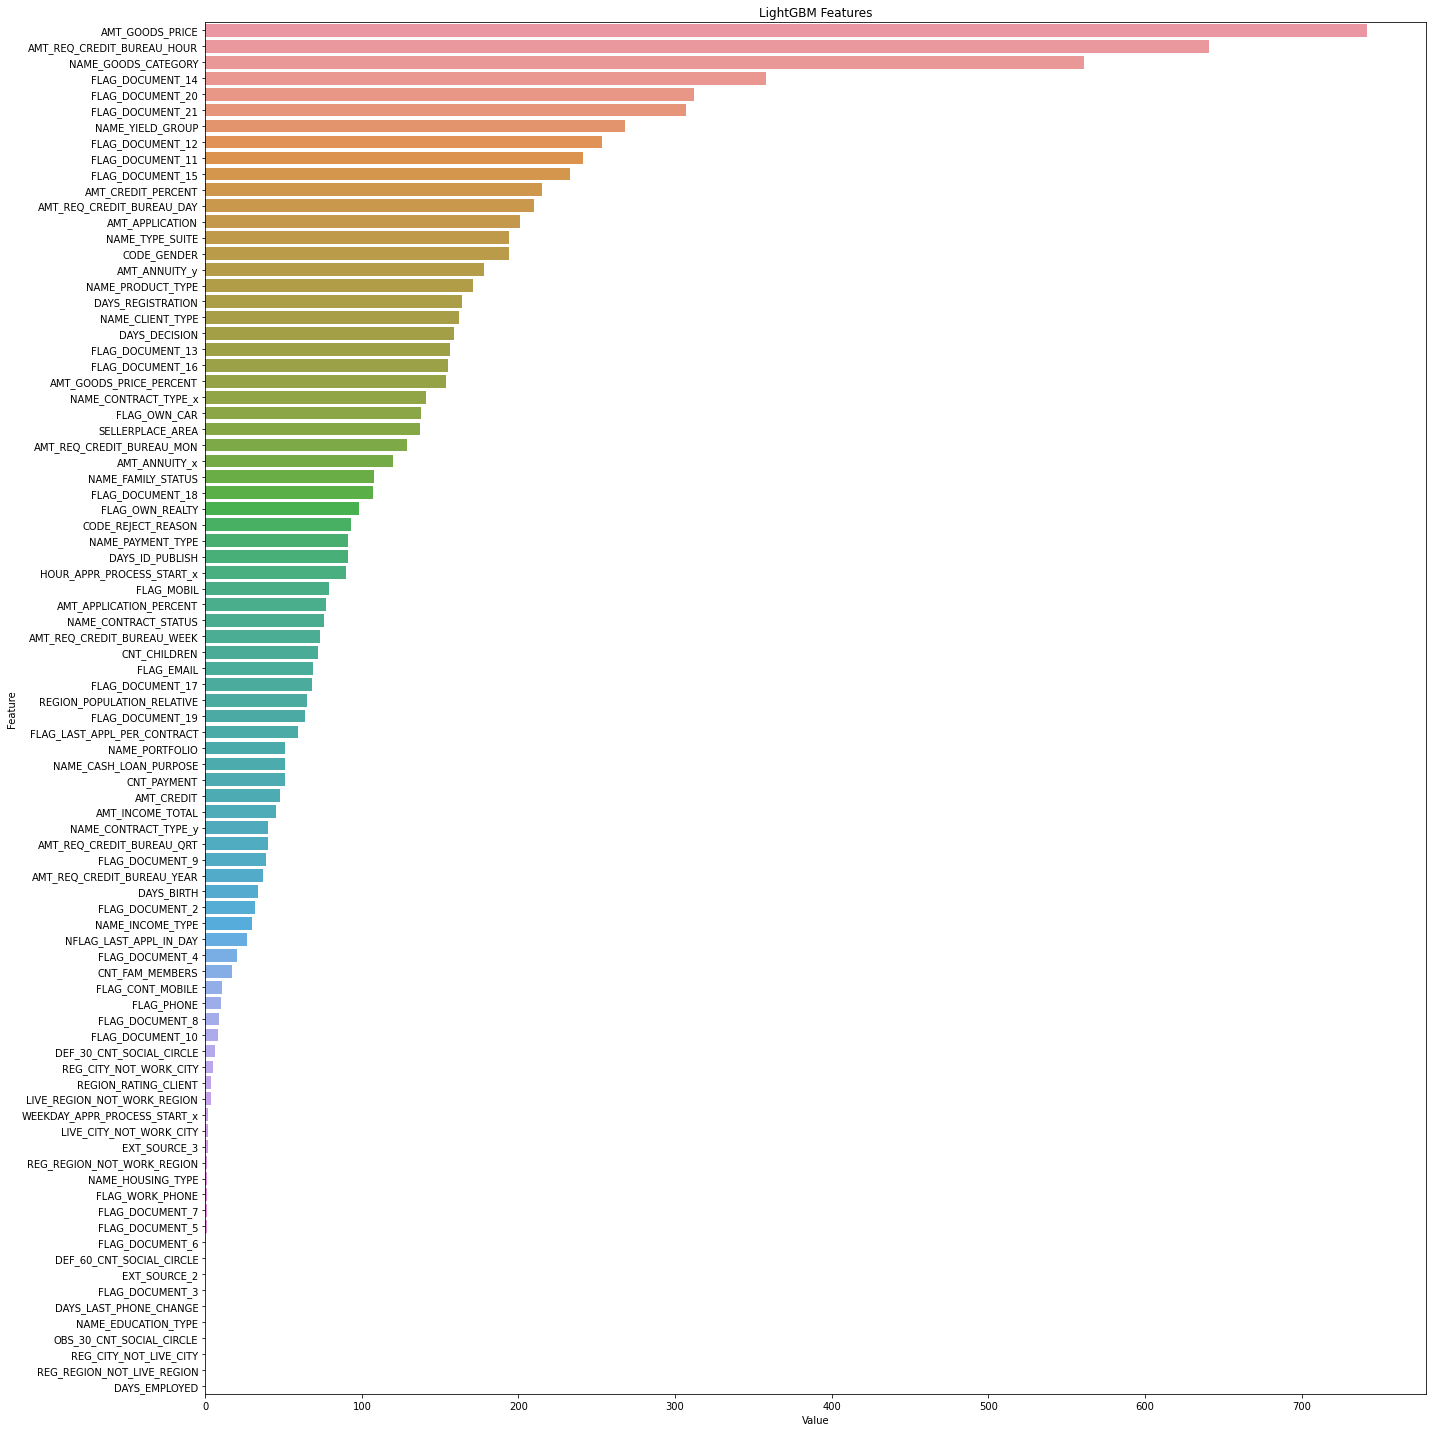

In [ ]:
feature_imp = pd.DataFrame(sorted(zip(lgb.feature_importances_,x.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 20))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()

In [132]:
# removing columns that has  0 effect on the "target" value
toRemove=[feat[1] for feat in sorted(zip(lgb.feature_importances_,x.columns)) if feat[0]==0]

In [133]:
#toRemove.remove('DAYS_EMPLOYED')
toRemove

['DAYS_EMPLOYED',
 'EXT_SOURCE_2',
 'FLAG_DOCUMENT_3',
 'FLAG_DOCUMENT_5',
 'FLAG_DOCUMENT_6',
 'FLAG_DOCUMENT_7',
 'LIVE_CITY_NOT_WORK_CITY',
 'NAME_EDUCATION_TYPE',
 'NAME_HOUSING_TYPE',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_REGION_NOT_LIVE_REGION',
 'WEEKDAY_APPR_PROCESS_START_x']

In [134]:
train_data_clean = train_data_use.drop(toRemove, axis=1)
test_data_clean = test_data_use.drop(toRemove, axis=1)

In [135]:
train_data_clean.head()

TARGET  NAME_CONTRACT_TYPE_x  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
0       1                     0            1             0                1   
1       0                     0            0             0                0   
2       0                     1            1             1                1   
3       0                     0            0             0                1   
4       0                     0            1             0                1   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY_x  NAME_TYPE_SUITE  \
0             0          202500.0    406597.5        24700.5                6   
1             0          270000.0   1293502.5        35698.5                1   
2             0           67500.0    135000.0         6750.0                6   
3             0          135000.0    312682.5        29686.5                6   
4             0          121500.0    513000.0        21865.5                6   

   NAME_INCOME_TYPE  NAME_FAMILY_STATUS  REGION_POPULATION_RELATIVE  \
0                 7                   3                    0.018801   
1                 4                   1                    0.003541   
2                 7                   3                    0.010032   
3                 7                   0                    0.008019   
4                 7                   3                    0.028663   

   DAYS_BIRTH  DAYS_REGISTRATION  DAYS_ID_PUBLISH  FLAG_MOBIL  \
0        9461            -3648.0            -2120           1   
1       16765            -1186.0             -291           1   
2       19046            -4260.0            -2531           1   
3       19005            -9833.0            -2437           1   
4       19932            -4311.0            -3458           1   

   FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  CNT_FAM_MEMBERS  \
0                0                 1           1           0              1.0   
1                0                 1           1           0              2.0   
2                1                 1           1           0              1.0   
3                0                 1           0           0              2.0   
4                0                 1           0           0              1.0   

   REGION_RATING_CLIENT  HOUR_APPR_PROCESS_START_x  \
0                     2                         10   
1                     1                         11   
2                     2                          9   
3                     2                         17   
4                     2                         11   

   REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  \
0                           0                            0   
1                           0                            0   
2                           0                            0   
3                           0                            0   
4                           0                            0   

   REG_CITY_NOT_WORK_CITY  EXT_SOURCE_3  DEF_30_CNT_SOCIAL_CIRCLE  \
0                       0      0.139376                       2.0   
1                       0           NaN                       0.0   
2                       0      0.729567                       0.0   
3                       0           NaN                       0.0   
4                       1           NaN                       0.0   

   DEF_60_CNT_SOCIAL_CIRCLE  DAYS_LAST_PHONE_CHANGE  FLAG_DOCUMENT_2  \
0                       2.0                 -1134.0                0   
1                       0.0                  -828.0                0   
2                       0.0                  -815.0                0   
3                       0.0                  -617.0                0   
4                       0.0                 -1106.0                0   

   FLAG_DOCUMENT_4  FLAG_DOCUMENT_8  FLAG_DOCUMENT_9  FLAG_DOCUMENT_10  \
0                0                0                0                 0   
1                0                0       

second run  to edit the documents 

In [136]:
train_data_clean.drop(['TARGET'],axis=1).to_csv('train_clean_data.csv')

In [137]:
train_data_clean.to_csv('new_train_clean_data.csv')

In [138]:
test_data_clean.to_csv('test_clean_data.csv')

In [139]:
# we will run a new test to see if we can get the target value
x = train_data_clean.drop(['TARGET'],axis=1).copy()
y = train_data_clean['TARGET'].copy()

In [140]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2,random_state=42)

In [141]:
# Fitting the model
lgb.fit(x_train, y_train)

LGBMClassifier(class_weight='balanced', learning_rate=0.05, n_estimators=300)

In [142]:
y_pred = lgb.predict(x_test)


<AxesSubplot:>

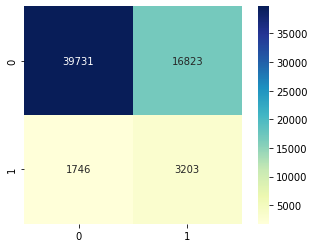

In [143]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
cm_matrix = pd.DataFrame(data=cm, columns=[0, 1], index=[0,1])

sns.heatmap(cm_matrix, square=True, annot=True, fmt='d', cmap='YlGnBu')

In [144]:
# Classification Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.70      0.81     56554
           1       0.16      0.65      0.26      4949

    accuracy                           0.70     61503
   macro avg       0.56      0.67      0.53     61503
weighted avg       0.89      0.70      0.77     61503



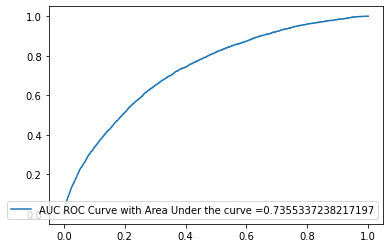

In [145]:
# To get Area Under Curve score
generate_auc_roc_curve(lgb, x_test)

In [146]:
# we creating a new " target" is the % and "class" if it's default or not 

# .drop(['TARGET','Class','SK_ID_CURR'], axis=1)
test_data_clean['TARGET'] = lgb.predict_proba(test_data_clean)[:,1]
test_data_clean['Class'] = lgb.predict(test_data_clean.drop(['TARGET'], axis=1))

In [147]:
x = train_data_clean.drop(['TARGET'],axis=1).copy()

In [148]:
# res_train = pd.DataFrame(columns=['SK_ID_CURR', 'TARGET', 'Class'])

In [149]:
train_data_clean['TARGET'] = lgb.predict_proba(x)
train_data_clean['Class'] = train_data['TARGET']

In [ ]:
train_data_clean['SK_ID_CURR'] = train_data['SK_ID_CURR']
test_data_clean['SK_ID_CURR'] = test_data['SK_ID_CURR']

In [ ]:
result = pd.concat([train_data_clean, test_data_clean], axis=0)
result = result.sort_values(by='SK_ID_CURR', ascending=True)

In [ ]:
result.head()

In [ ]:
feature_imp = pd.DataFrame(sorted(zip(lgb.feature_importances_,x.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data = feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()

In [ ]:
result.to_csv('/content/drive/MyDrive/Openclassroom/Cas7/Project7V3/result.csv', index=False)

In [ ]:
##### this is the connected part of the APP

In [ ]:
plt.figure(figsize=(8, 8))

labels=['Default', 'Non-Default']
sizes=[result[result['Class']==1]['Class'].count(), result[result['Class']==0]['Class'].count()]

plt.pie(sizes, labels=labels, 
        autopct='%1.1f%%', 
        shadow=True,
        startangle=200,
        explode = [0, 0.1])

plt.axis('equal')
plt.savefig("PieChart.png")
plt.show()

In [ ]:
amtCredit=result.sort_values(by='AMT_CREDIT', ascending=False)[['SK_ID_CURR', 'AMT_CREDIT']]
amtCredit.set_index('SK_ID_CURR')[:20].plot.barh(figsize=(10, 10))
plt.savefig("/content/drive/MyDrive/Ali/images/CreditAmount.png")

In [ ]:
[feat[1] for feat in sorted(zip(lgb.feature_importances_,x.columns)) if feat[0]>=100]

In [ ]:
focus={'AMT_CREDIT_PERCENT': "the average between the loan and the income",
       'AMT_APPLICATION':'For how much credit did client ask on the previous application',
'DAYS_EMPLOYED':'How many days before the application the person started current employment',
'DAYS_BIRTH':"Client's age in days at the time of application",
'AMT_GOODS_PRICE':'Goods price of good that client asked for (if applicable) on the previous application',
'AMT_ANNUITY_x':'Annuity of previous application',
'AMT_INCOME_TOTAL':'Income of the client',
'AMT_CREDIT':' Credit amount of the loan'}

In [ ]:
result['DAYS_BIRTH']

In [ ]:
id=394688

In [ ]:
result['DAYS_BIRTH']=abs(result['DAYS_BIRTH'])
client=result[result['SK_ID_CURR']==id]
sameClass=result[result['Class']==int(client['Class'].values[0])]
if int(client['Class'])==1:
    oppClass=result[result['Class']==0]
else:
    oppClass=result[result['Class']==1]

for key, val in focus.items():
    temp=pd.DataFrame(columns=['Target','Average','SameGroup','OppGroup'])
    temp['Target']=client[key]
    temp['Average']=np.average(result[key].values)
    temp['SameGroup']=np.average(sameClass[key].values)
    temp['OppGroup']=np.average(oppClass[key].values)
    temp=temp.T
    plt.figure(figsize=(10, 5))
    plt.barh(temp.index, temp[temp.columns[0]], color=plt.cm.Accent_r(np.arange(len(temp))))
    plt.savefig("/content/drive/MyDrive/Ali/images/"+key+".png")
    plt.show()

### Plotting the Comparison between the Variables

In [ ]:
results = pd.read_csv('/content/drive/MyDrive/Openclassroom/Cas7/Project7V3/result.csv')

In [ ]:
results.head()

In [ ]:
results['YEARS_BIRTH'] = np.round(abs(results['DAYS_BIRTH']/365),2)
results.tail()

In [ ]:
results.describe()

In [ ]:
client_id = 456251

In [ ]:
# Extracting the data for given client id
df = results[results['SK_ID_CURR']==client_id]

In [ ]:
df

In [ ]:
# Let us plot Age vs Income total amount
x = df['AMT_INCOME_TOTAL'].values
y = df['YEARS_BIRTH'].values
plt.figure(figsize=(10,15))
plt.scatter(results['AMT_INCOME_TOTAL'], results['YEARS_BIRTH'])
plt.xlim(0.0, 2.025000e+06)
plt.axvline(x = x, color='r')
plt.axhline(y = y, color='b')
plt.text(x, y, (x[0],y[0]), fontsize=20)
plt.xlabel('Income Total Amount')
plt.ylabel('Age')


In [ ]:
# Let us plot Age vs Credit Amount
x = df['AMT_CREDIT'].values
y = df['YEARS_BIRTH'].values
plt.figure(figsize=(10,15))
plt.scatter(results['AMT_CREDIT'], results['YEARS_BIRTH'])
plt.xlim(0.0, 4.050000e+06)
plt.axvline(x = x, color='r')
plt.axhline(y = y, color='b')
plt.text(x, y, (x[0],y[0]), fontsize=20)
plt.xlabel('Credit Amount')
plt.ylabel('Age')


In [ ]:
# Let us plot Age vs Annuity_x Amount
x = df['AMT_ANNUITY_x'].values
y = df['YEARS_BIRTH'].values
plt.figure(figsize=(10,15))
plt.scatter(results['AMT_ANNUITY_x'], results['YEARS_BIRTH'])
plt.xlim(0.0, 258025.500000)
plt.axvline(x = x, color='r')
plt.axhline(y = y, color='b')
plt.text(x, y, (x[0],y[0]), fontsize=20)
plt.xlabel('Annuity_x Amount')
plt.ylabel('Age')

In [ ]:
# Let us plot Age vs Annuity_y Amount
x = df['AMT_ANNUITY_y'].values
y = df['YEARS_BIRTH'].values
plt.figure(figsize=(10,15))
plt.scatter(results['AMT_ANNUITY_y'], results['YEARS_BIRTH'])
plt.xlim(0.0, 300425.445000)
plt.axvline(x = x, color='r')
plt.axhline(y = y, color='b')
plt.text(x, y, (x[0],y[0]), fontsize=20)
plt.xlabel('Annuity_y Amount')
plt.ylabel('Age')

In [ ]:
# Let us plot Age vs Application Amount
x = df['AMT_APPLICATION'].values
y = df['YEARS_BIRTH'].values
plt.figure(figsize=(10,15))
plt.scatter(results['AMT_APPLICATION'], results['YEARS_BIRTH'])
plt.xlim(0.0, 4.050000e+06)
plt.axvline(x = x, color='r')
plt.axhline(y = y, color='b')
plt.text(x, y, (x[0],y[0]), fontsize=20)
plt.xlabel('Application Amount')
plt.ylabel('Age')

In [ ]:
#streamlit graph 

###Importance feat
plt.figure(figsize=(15,6))
X_train, X_test, y_train, y_test = train_test_split(current_data, labels.values, random_state=42)
logistic_reg_coeff = trained_models[1]["model"]["clf"].coef_
color_list =  sns.color_palette("dark", len(current_data.columns)) 
top_x = 10
logistic_reg_coeff = trained_models[1]["model"]["clf"].coef_[0]
idx = np.argsort(np.abs(logistic_reg_coeff))[::-1] 
lreg_ax = plt.barh(current_data.columns[idx[:top_x]][::-1], logistic_reg_coeff[idx[:top_x]][::-1])
for i,bar in enumerate(lreg_ax):
  bar.set_color(color_list[idx[:top_x][::-1][i]])
  plt.box(False) 
lr_title = plt.suptitle("Logistic Regression. Top " + str(top_x) + " Coefficients.", fontsize=20, fontweight="normal")

In [ ]:
###' LIME

current_model = trained_models[3] # Explain the Random Forest Model
clf = current_model["model"]["clf"]
scaler = current_model["model"]["scaler"]
scaled_train_data = scaler.transform(X_train)
sub_sampled_train_data = shap.sample(scaled_train_data, 600, random_state=0) # use 600 samples of train data as background data

scaled_test_data = scaler.transform(X_test) 
subsampled_test_data =scaled_test_data[test_data_index].reshape(1,-1)

start_time = time.time()
explainer = shap.KernelExplainer(clf.predict_proba, sub_sampled_train_data)
shap_values = explainer.shap_values(subsampled_test_data,  l1_reg="aic")
elapsed_time = time.time() - start_time
# explain first sample from test data
print("Kernel Explainer SHAP run time", round(elapsed_time,3) , " seconds. ", current_model["name"])
print("SHAP expected value", explainer.expected_value)
print("Model mean value", clf.predict_proba(scaled_train_data).mean(axis=0))
print("Model prediction for test data", clf.predict_proba(subsampled_test_data))
shap.initjs()
pred_ind = 0
shap.force_plot(explainer.expected_value[1], shap_values[1][0], subsampled_test_data[0], feature_names=X_train.columns)
